# Feedback - Midpoint Presentation
- Clear objective
- Add a nice visual for joining of datasets together
- He wants code in our slides (never heard of this as a recommendation)
- Comment our code, describe intent of each join and action
- TIME SERIES DATA: need to split data for test/validation conscientiously (my thoughts: random sample the same dates of the year for all datasets)
  - Vini posted this on the channel: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4#:~:text=Cross%20Validation%20on%20Time%20Series,for%20the%20forecasted%20data%20points
- Slide Numbers
- No pie charts (those weren't ours at least)
- Geoplots and more visuals for EDA
- Seasonality and time plots over years
- Clarity of data used (which datasets and what size)
- Metrics and comparison baseline values (Why are we doing the project? What is our focus? Objectively, how well are we doing?)
- More creative in the feature engineering
- Graph features and components
- Persistent storage
- RDDs
- Use more than just LogReg (pagerank/RF)
- Name dataset on each slide for the EDA
- Block diagrams about pipelines (workflow/preprocessing/experimental framework)
- "75% missing values in 3m data does not mean that the feature is useless" (think about features added in later years. Look at last 3 months of 2019?)
- Normalize our features before modeling
- Joint variable: Airport + wind angle (since crosswinds are critical and are airport-specific)
- Encode variable types correctly (for example, year is categorical - not numeric)

notes:
- Decrease specificity because it looks better for the airline to overperform (makes customer happier when the delay doesn't happen)
- ^ do that by oversampling delayed flights
- Aggregate weather features

# Delayed Flight Predictions
W261 Machine Learning At Scale | Summer 2021, Section 002

Team 7 | Michael Bollig, Emily Brantner, Sarah Iranpour, Abhi Sharma

## Section 1 - Question Formulation

FILL OUT

## Section 2 - EDA & Discussion of Challenges
Before building our predictive system, we need to develop a deep understanding of the data being worked with. In this section we focus on cleaning, joining, and exploring the provided datasets. The workflow we implement follows this general structure:
<br>
<br>
1. Loading and cleaning each provided dataset individually
2. Joining together all of the cleaned data onto a single cohesive table
3. Verification of data for the provided features
4. Exploration of the provided features

First, we'll load in the required modules and configure our cloud storage:

In [0]:
from pyspark.sql.functions import col, substring, split, when, lit, max as pyspark_max, countDistinct, count, mean,\
sum as pyspark_sum, expr, unix_timestamp, to_utc_timestamp, to_timestamp, concat, length, row_number
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType
import pandas as pd
from gcmap import GCMapper, Gradient
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
import graphframes as gf

blob_container = "w261team07container" # The name of your container created in https://portal.azure.com
storage_account = "w261team07storage" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261team07" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261team07-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

### Section 2.1 - Core Datasets
For this predictive modeling task, three primary datasets have been provided to be used: a flights table, a weather station table, and a weather table. In order to get a baseline understanding of these datasets, the first quarter data from 2015 will be loaded for all three tables. The flights table has additionally been preprocessed to only contain flights originating from the two busiest US airports: Chicago (ORD) and Atlanta (ATL). The data is first loaded into Spark dataframes from the raw parquet files:

In [0]:
# Load 2015 Q1 for Flights
df_airlines = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data_3m/")

# Load the 2015 Q1 for Weather
df_weather = spark.read.parquet("/mnt/mids-w261/datasets_final_project/weather_data/*").filter(col('DATE') < "2015-04-01T00:00:00.000")

# Load the weather stations data
df_stations = spark.read.parquet("/mnt/mids-w261/datasets_final_project/stations_data/*")

# Describe dataset sizes
print(f"The Q1 2015 dataset for ORD and ATL airports contains {df_airlines.count()} records, with {len(df_airlines.columns)} columns.")
print(f"The Q1 2015 NOAA dataset for weather recordings contains {df_weather.count()} records, with {len(df_weather.columns)} columns.")
print(f"The NOAA weather station dataset contains {df_stations.count()} records, with {len(df_stations.columns)} columns.")

#### Airline Flight Data
We begin with the flights table in order to better understand the available features. To start, we examine the first 10 records are alongside the provided schema.

In [0]:
display(df_airlines.limit(10))
df_airlines.printSchema()

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 2015 1 2 1 7 2015-02-01 AA 19805 AA N3MEAA 392 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 12953 1295302 31703 LGA New York, NY NY 36 New York 22 730 749 19.0 19.0 1.0 1 0700-0759 34.0 823 1056 4.0 1030 1100 30.0 30.0 1.0 2 1000-1059 0.0 null 0.0 120.0 131.0 93.0 1.0 733.0 3 0.0 19.0 11.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 2 2 1 2015-02-02 AA 19805 AA N3LPAA 392 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 12953 1295302 31703 LGA New York, NY NY 36 New York 22 730 null null null null null 0700-0759 null null null null 1030 null null null null null 1000-1059 1.0 B 0.0 120.0 null null 1.0 733.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 2 3 2 2015-02-03 AA 19805 AA N3LXAA 392 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 12953 1295302 31703 LGA New York, NY NY 36 New York 22 730 735 5.0 5.0 0.0 0 0700-0759 19.0 754 1027 9.0 1030 1036 6.0 6.0 0.0 0 1000-1059 0.0 null 0.0 120.0 121.0 93.0 1.0 733.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 2 4 3 2015-02-04 AA 19805 AA N3LHAA 392 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 12953 1295302 31703 LGA New York, NY NY 36 New York 22 730 727 -3.0 0.0 0.0 -1 0700-0759 11.0 738 1008 5.0 1030 1013 -17.0 0.0 0.0 -2 1000-1059 0.0 null 0.0 120.0 106.0 90.0 1.0 733.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 2 5 4 2015-02-05 AA 19805 AA N3LYAA 392 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 12953 1295302 31703 LGA New York, NY NY 36 New York 22 730 757 27.0 27.0 1.0 1 0700-0759 23.0 820 1058 3.0 1030 11

root
-- YEAR: integer (nullable = true)
-- QUARTER: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- FL_DATE: string (nullable = true)
-- OP_UNIQUE_CARRIER: string (nullable = true)
-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- OP_CARRIER_FL_NUM: integer (nullable = true)
-- ORIGIN_AIRPORT_ID: integer (nullable = true)
-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
-- ORIGIN: string (nullable = true)
-- ORIGIN_CITY_NAME: string (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- ORIGIN_STATE_FIPS: integer (nullable = true)
-- ORIGIN_STATE_NM: string (nullable = true)
-- ORIGIN_WAC: integer (nullable = true)
-- DEST_AIRPORT_ID: integer (nullable = true)
-- DEST_AIRPORT_SEQ_ID: integer (nullable = true)
-- DEST_CITY_MARKET_ID: integer (nullable = true)
-- DEST: string (nullable = true)
-- DEST_CITY_NAME: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEST_STATE_FIPS: integer (nullable = true)
-- DEST_STATE_NM: string (nullable = true)
-- DEST_WAC: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- DEP_TIME: integer (nullable = true)
-- DEP_DELAY: double (nullable = true)
-- DEP_DELAY_NEW: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- DEP_DELAY_GROUP: integer (nullable = true)
-- DEP_TIME_BLK: string (nullable = true)
-- TAXI_OUT: double (nullable = true)
-- WHEELS_OFF: integer (nullable = true)
-- WHEELS_ON: integer (nullable = true)
-- TAXI_IN: double (nullable = true)
-- CRS_ARR_TIME: integer (nullable = true)
-- ARR_TIME: integer (nullable = true)
-- ARR_DELAY: double (nullable = true)
-- ARR_DELAY_NEW: double (nullable = true)
-- ARR_DEL15: double (nullable = true)
-- ARR_DELAY_GROUP: integer (nullable = true)
-- ARR_TIME_BLK: string (nullable = true)
-- CANCELLED: double (nullable = true)
-- CANCELLATION_CODE: string (nullable = true)
-- DIVERTED: double (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)
-- ACTUAL_ELAPSED_TIME: double (nullable = true)
-- AIR_TIME: double (nullable = true)
-- FLIGHTS: double (nullable = true)
-- DISTANCE: double (nullable = true)
-- DISTANCE_GROUP: integer (nullable = true)
-- CARRIER_DELAY: double (nullable = true)
-- WEATHER_DELAY: double (nullable = true)
-- NAS_DELAY: double (nullable = true)
-- SECURITY_DELAY: double (nullable = true)
-- LATE_AIRCRAFT_DELAY: double (nullable = true)
-- FIRST_DEP_TIME: integer (nullable = true)
-- TOTAL_ADD_GTIME: double (nullable = true)
-- LONGEST_ADD_GTIME: double (nullable = true)
-- DIV_AIRPORT_LANDINGS: integer (nullable = true)
-- DIV_REACHED_DEST: double (nullable = true)
-- DIV_ACTUAL_ELAPSED_TIME: double (nullable = true)
-- DIV_ARR_DELAY: double (nullable = true)
-- DIV_DISTANCE: double (nullable = true)
-- DIV1_AIRPORT: string (nullable = true)
-- DIV1_AIRPORT_ID: integer (nullable = true)
-- DIV1_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV1_WHEELS_ON: integer (nullable = true)
-- DIV1_TOTAL_GTIME: double (nullable = true)
-- DIV1_LONGEST_GTIME: double (nullable = true)
-- DIV1_WHEELS_OFF: integer (nullable = true)
-- DIV1_TAIL_NUM: string (nullable = true)
-- DIV2_AIRPORT: string (nullable = true)
-- DIV2_AIRPORT_ID: integer (nullable = true)
-- DIV2_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV2_WHEELS_ON: integer (nullable = true)
-- DIV2_TOTAL_GTIME: double (nullable = true)
-- DIV2_LONGEST_GTIME: double (nullable = true)
-- DIV2_WHEELS_OFF: integer (nullable = true)
-- DIV2_TAIL_NUM: string (nullable = true)
-- DIV3_AIRPORT: string (nullable = true)
-- DIV3_AIRPORT_ID: integer (nullable = true)
-- DIV3_AIRPORT_SEQ_ID: integer (nullable = true)
-- DIV3_WHEELS_ON: integer (nullable = true)
-- DIV3_TOTAL_GTIME: double (nullable = true)
-- DIV3_LONGEST_GTIME: double (nullable = true)
-- DIV3_WHEELS_

#### Airline Data Cleaning Summary
The airlines dataset is robust, with some features that were redundant, could be combined or needed to be added. We changed the names of the variables for ease of use, and our more technical changes are detailed below.

##### Feature removal
- additional names for airline carriers, airports, cities, and states removed, leaving OP_UNIQUE_CARRIER, ORIGIN/DEST_AIRPORT_ID, ORIGIN/DEST, ORIGIN/DEST_STATE_ABR, ORIGIN/DEST_CITY_NAME 
- removed information about dept, 2nd, 3rd, 4th, and 5th diverted flights. Because we're only looking at whether a flight is or is not 15 minutes delayed, and not HOW delayed it is, any diversion is going to knock a flight more than 15 minutes off track, and the 4th and 5th diverted flights are all NULL in the 3mo dataset.
- removed aditional gate departure time columns as that departure time is built into the departure delay.

##### Feature combinations
- to make up for removing the information about the specific diverted flights, we added the diverted flight arrival delays into the arrival delay. Diverted delays previously had their own column and now they're combined. We know what the delay is from based on the diverted column showing 1 or 0.
- cancellations were added as 1s into the outcome variable dep_is_delayed

##### Null Values
- the NULL values are generally where canceled flights do not have a departure time, or flights that aren't diverted don't have a flight diversion time (and other cases along those lines). For now, we're leaving them as NULL, although we may have to change them to non-nulls depending on the model we use.

##### Duplicate values

##### Additional datasets and timezones
- because the original dataset uses local timezone and does not have the same airport code type as our weather data, we joined the open airlines dataset which has both timezones and the ICAO airport codes. As a bonus, we also have altitude information about the airport in this dataset
- because we wouldn't be able to see the future, our "time_at_prediction_utc" feature is the time at which we'd be predicting the delay.

In [0]:
def clean_airline_data(df):
  # drop duplicate entries and create temporary view of airlines data
  df.drop_duplicates().createOrReplaceTempView('df_tmp')
  
  # load OpenAirlines data for ICAO code and Timezone
  df_open_airlines = spark.read.csv('dbfs:/FileStore/shared_uploads/mbollig@berkeley.edu/airports.dat', header=False, inferSchema= False)\
                          .toDF("airport_id", "name", "city", "country", "IATA", "ICAO", "latitude", "longitude", "altitude", "utc_offset", "DST", "timezone", "type", "source")
    
  # create temporary view of OpenAirlines data
  df_open_airlines.createOrReplaceTempView('open_airlines')
  
  # structure query to change data types, add open_airlines, removed and combine base features, and change timezones
  query = '''
          
  SELECT 
     ROW_NUMBER() OVER (ORDER BY FL_DATE, DEP_TIME, TAIL_NUM) as index_id
     , string(oao.ICAO) as origin_ICAO
     , cast(oao.utc_offset as INTEGER) as origin_utc_offset
     , oao.timezone as origin_timezone
     , oao.latitude as origin_latitude
     , oao.longitude as origin_longitude
     , oao.altitude as origin_altitude
     , string(oad.ICAO) as dest_ICAO
     , cast(oad.utc_offset as INTEGER) as dest_utc_offset
     , oad.timezone as dest_timezone
     , oad.latitude as dest_latitude
     , oad.longitude as dest_longitude
     , oad.altitude as dest_altitude
     , string(YEAR) as year
     , string(QUARTER) as quarter
     , string(MONTH) as month
     , string(DAY_OF_MONTH) as day_of_month
     , string(DAY_OF_WEEK) as day_of_week
     , FL_DATE as dt                                  -- date of flight departure
     , string(OP_UNIQUE_CARRIER) as carrier
     , string(TAIL_NUM) as tail_num
     , string(OP_CARRIER_FL_NUM) as flight_num
     , ORIGIN_STATE_ABR as origin_state
     , ORIGIN_CITY_NAME as origin_city
     , string(ORIGIN_AIRPORT_ID) as origin_airport_id         -- airport codes can change, this stays constant
     , string(ORIGIN) as origin_airport_code
     , DEST_STATE_ABR as dest_state
     , DEST_CITY_NAME as dest_city
     , string(DEST_AIRPORT_ID) as dest_airport_id
     , string(DEST) as dest_airport_code
     , CASE
         WHEN LENGTH(CRS_DEP_TIME) = 1 THEN CONCAT('000', CRS_DEP_TIME)
         WHEN LENGTH(CRS_DEP_TIME) = 2 THEN CONCAT('00', CRS_DEP_TIME)
         WHEN LENGTH(CRS_DEP_TIME) = 3 THEN CONCAT('0', CRS_DEP_TIME)
         WHEN CRS_DEP_TIME = 2400 THEN 2359       -- 2400 is not a valid HHMM, moving back 1 minute
         ELSE CRS_DEP_TIME
       END as planned_dep_time
     , DEP_TIME as actual_dep_time
     , IFNULL(DEP_DELAY, 0) as delay_minutes                  -- negatives mean early
     , boolean(CASE
         WHEN CANCELLED = 1 THEN 1
         ELSE DEP_DEL15
       END) as dep_is_delayed                 -- OUTCOME VARIABLE, includes cancelled flights as 1 as well
     , string(DEP_DELAY_GROUP) as dep_delay_group
     , string(DEP_TIME_BLK) as dep_hour
     , ARR_TIME as actual_arr_time
     , CASE
         WHEN DIV_ARR_DELAY IS NOT NULL THEN DIV_ARR_DELAY    -- added diverted delays to arrival delays
         ELSE ARR_DELAY
       END as arr_delay_minutes                    -- negatives mean early (now includes diverted flights)
     , string(ARR_DELAY_GROUP) as arr_delay_group
     , string(ARR_TIME_BLK) as arr_hour
     , boolean(CANCELLED) as canceled
     , string(CANCELLATION_CODE) as cancel_code            -- B = weather, A = airline, C = National Air System, D = security
     , boolean(DIVERTED) as is_diverted
     , CRS_ELAPSED_TIME as planned_duration
     , ACTUAL_ELAPSED_TIME as actual_duration
     , FLIGHTS as num_flights
     , DISTANCE as flight_distance
     , string(DISTANCE_GROUP) as distance_group
     , CARRIER_DELAY as carrier_delay
     , WEATHER_DELAY as weather_delay
     , NAS_DELAY as nas_delay
     , SECURITY_DELAY as security_delay
     , LATE_AIRCRAFT_DELAY as late_aircraft_delay
     -- not including gate_departure info for flights that returned to the gate since wrapped up in delay times for previous flights
     , boolean(DIV_REACHED_DEST) as div_reached_dest
     -- not including most diverted information as not super relevant outside of knowing that it was diverted and adding the diverted arrival delay to the arrival_delay column
  FROM {0} a
  LEFT JOIN {1} oao
    ON oao.IATA = ORIGIN
  LEFT JOIN {1} oad
    ON oad.IATA = DEST

'''.format('df_tmp', 'open_airlines')

  
  # change data types, add open_airlines, remove and combine base features, and change timezones
  df_with_tz = spark.sql(query)\
      .withColumn('planned_departure_utc', to_utc_timestamp(to_timestamp(concat(col('dt'), col('planned_dep_time')), 'yyyy-MM-ddHHmm'), col('origin_timezone')))\
      .withColumn('time_at_prediction_utc', to_utc_timestamp(to_timestamp(concat(col('dt'), col('planned_dep_time')), 'yyyy-MM-ddHHmm'), col('origin_timezone')) + expr('INTERVAL -2 HOURS'))\
  
  return df_with_tz

In [0]:
df_airlines_clean = clean_airline_data(df_airlines)
display(df_airlines_clean.limit(10))

# write
df_airlines_clean.write.mode('overwrite').parquet(f"{blob_url}/airlines_eda_v1")

origin_ICAO origin_utc_offset origin_timezone origin_latitude origin_longitude origin_altitude dest_ICAO dest_utc_offset dest_timezone dest_latitude dest_longitude dest_altitude index_id year quarter month day_of_month day_of_week dt carrier tail_num flight_num origin_state origin_city origin_airport_id origin_airport_code dest_state dest_city dest_airport_id dest_airport_code planned_dep_time actual_dep_time delay_minutes dep_is_delayed dep_delay_group dep_hour actual_arr_time arr_delay_minutes arr_delay_group arr_hour canceled cancel_code is_diverted planned_duration actual_duration num_flights flight_distance distance_group carrier_delay weather_delay nas_delay security_delay late_aircraft_delay div_reached_dest planned_departure_utc time_at_prediction_utc KORD -6 America/Chicago 41.9786 -87.9048 672 KMIA -5 America/New_York 25.79319953918457 -80.29060363769531 8 1 2015 1 1 1 4 2015-01-01 F9 null 1256 IL Chicago, IL 13930 ORD FL Miami, FL 13303 MIA 0600 null 0.0 1.0 null 0600-0659 null null null 1000-1059 1.0 A 0.0 180.0 null 1.0 1197.0 5 null null null null null null 2015-01-01T12:00:00.000+0000 2015-01-01T10:00:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KDEN -7 America/Denver 39.861698150635 -104.672996521 5431 2 2015 1 1 1 4 2015-01-01 UA null 1143 IL Chicago, IL 13930 ORD CO Denver, CO 11292 DEN 1627 null 0.0 1.0 null 1600-1659 null null null 1800-1859 1.0 B 0.0 166.0 null 1.0 888.0 4 null null null null null null 2015-01-01T22:27:00.000+0000 2015-01-01T20:27:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KPHL -5 America/New_York 39.87189865112305 -75.24109649658203 36 3 2015 1 1 1 4 2015-01-01 UA null 1412 IL Chicago, IL 13930 ORD PA Philadelphia, PA 14100 PHL 1010 null 0.0 1.0 null 1000-1059 null null null 1300-1359 1.0 A 0.0 121.0 null 1.0 678.0 3 null null null null null null 2015-01-01T16:10:00.000+0000 2015-01-01T14:10:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KEGE -7 America/Denver 39.64260101 -106.9179993 6548 4 2015 1 1 1 4 2015-01-01 AA N005AA 1080 IL Chicago, IL 13930 ORD CO Eagle, CO 11503 EGE 1145 null 0.0 1.0 null 1100-1159 null null null 1300-1359 1.0 A 0.0 170.0 null 1.0 1007.0 5 null null null null null null 2015-01-01T17:45:00.000+0000 2015-01-01T15:45:00.000+0000 KATL -5 America/New_York 33.6367 -84.428101 1026 KDFW -6 America/Chicago 32.896801 -97.038002 607 5 2015 1 1 1 4 2015-01-01 AA N025AA 1635 GA Atlanta, GA 10397 ATL TX Dallas/Fort Worth, TX 11298 DFW 0625 null 0.0 1.0 null 0600-0659 null null null 0700-0759 1.0 B 0.0 150.0 null 1.0 731.0 3 null null null null null null 2015-01-01T11:25:00.000+0000 2015-01-01T09:25:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KDFW -6 America/Chicago 32.896801 -97.038002 607 6 2015 1 1 1 4 2015-01-01 AA N4YFAA 2335 IL Chicago, IL 13930 ORD TX Dallas/Fort Worth, TX 11298 DFW 1450 null 0.0 1.0 null 1400-1459 null null null 1700-1759 1.0 B 0.0 150.0 null 1.0 802.0 4 null null null null null null 2015-01-01T20:50:00.000+0000 2015-01-01T18:50:00.000+0000 KATL -5 America/New_York 33.6367 -84.428101 1026 KDFW -6 America/Chicago 32.896801 -97.038002 607 7 2015 1 1 1 4 2015-01-01 NK N618NK 144 GA Atlanta, GA 10397 ATL TX Dallas/Fort Worth, TX 11298 DFW 1124 null 0.0 1.0 null 1100-1159 null null null 1200-1259 1.0 B 0.0 148.0 null 1.0 731.0 3 null null null null null null 2015-01-01T16:24:00.000+0000 2015-01-01T14:24:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KCID -6 America/Chicago 41.884700775146484 -91.71080017089844 869 8 2015 1 1 1 4 2015-01-01 MQ N633MQ 3172 IL Chicago, IL 13930 ORD IA Cedar Rapids/Iowa City, IA 11003 CID 1330 null 0.0 1.0 null 1300-1359 null null null 1400-1459 1.0 A 0.0 68.0 null 1.0 196.0 1 null null null null null null 2015-01-01T19:30:00.000+0000 2015-01-01T17:30:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KBWI -5 America/New_York 39.1754 -76.668297 146 9 2015 1 1 1 4 2015-01-01 MQ N692MQ 3058 IL Chicago, IL 13930 ORD MD Baltimore, MD 10821 BWI 1135 null 0.0 1.0 null 

FILL OUT: comment on cleaned results

#### Weather Station Location Data
Next, the weather station table will be explored in order to better understand the available features. To start, the first 10 records are printed alongside the provided schema.

In [0]:
display(df_stations.limit(10))
df_stations.printSchema()

usaf wban station_id lat lon neighbor_id neighbor_name neighbor_state neighbor_call neighbor_lat neighbor_lon distance_to_neighbor 690020 93218 69002093218 36.0 -121.233 69002093218 JOLON HUNTER LIGGETT MIL RES CA KHGT 36.0 -121.233 0.0 690020 93218 69002093218 36.0 -121.233 69007093217 FRITZSCHE AAF CA KOAR 36.683 -121.767 55.73024537916726 690020 93218 69002093218 36.0 -121.233 69014093101 EL TORO MCAS CA KNZJ 33.667 -117.733 255.49106220353934 690020 93218 69002093218 36.0 -121.233 70027127506 BARROW POINT BARROW AK KPBA 71.333 -156.65 2750.4353299559803 690020 93218 69002093218 36.0 -121.233 70045027512 LONELY AK LNI 70.917 -153.25 2676.3554370627153 690020 93218 69002093218 36.0 -121.233 70063027403 OLIKTOK POW 2 AK POLI 70.5 -149.883 2604.050248854232 690020 93218 69002093218 36.0 -121.233 70063526465 GALBRAITH LAKE AIRPORT AK PAGB 68.479 -149.49 2490.9756094472277 690020 93218 69002093218 36.0 -121.233 70063627405 PRUDHOE BAY AK PAUD 70.25 -148.333 2568.180281844432 690020 93218 69002093218 36.0 -121.233 70104626418 CENTRAL AIRPORT AK PACE 65.567 -144.765 2254.5584891291946 690020 93218 69002093218 36.0 -121.233 70119526625 SHISHMAREF/NEW AIRPORT AK PASH 66.25 -166.089 2743.6881828292408

root
-- usaf: string (nullable = true)
-- wban: string (nullable = true)
-- station_id: string (nullable = true)
-- lat: double (nullable = true)
-- lon: double (nullable = true)
-- neighbor_id: string (nullable = true)
-- neighbor_name: string (nullable = true)
-- neighbor_state: string (nullable = true)
-- neighbor_call: string (nullable = true)
-- neighbor_lat: double (nullable = true)
-- neighbor_lon: double (nullable = true)
-- distance_to_neighbor: double (nullable = true)

FILL OUT: Explain cleaning steps

In [0]:
# clean station data
df_stations_clean = df_stations.filter(col("distance_to_neighbor") == 0).select('station_id','neighbor_call')

# write full dataset
df_stations_clean.write.mode('overwrite').parquet(f"{blob_url}/stations_clean_full")

#### Weather Observation Data
Next, we'll take a peek at our NOAA [weather dataset](https://www.ncdc.noaa.gov/orders/qclcd/)

FILL OUT: Subsetting to ORD/ATL

In [0]:
df_weather_subset = df_weather.filter((col("STATION") == '72219013874') | (col("STATION") == '72530094846'))
display(df_weather_subset.limit(10))

STATION DATE SOURCE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE CALL_SIGN QUALITY_CONTROL WND CIG VIS TMP DEW SLP AW1 GA1 GA2 GA3 GA4 GE1 GF1 KA1 KA2 MA1 MD1 MW1 MW2 OC1 OD1 OD2 REM EQD AW2 AX4 GD1 AW5 GN1 AJ1 AW3 MK1 KA4 GG3 AN1 RH1 AU5 HL1 OB1 AT8 AW7 AZ1 CH1 RH3 GK1 IB1 AX1 CT1 AK1 CN2 OE1 MW5 AO1 KA3 AA3 CR1 CF2 KB2 GM1 AT5 AY2 MW6 MG1 AH6 AU2 GD2 AW4 MF1 AA1 AH2 AH3 OE3 AT6 AL2 AL3 AX5 IB2 AI3 CV3 WA1 GH1 KF1 CU2 CT3 SA1 AU1 KD2 AI5 GO1 GD3 CG3 AI1 AL1 AW6 MW4 AX6 CV1 ME1 KC2 CN1 UA1 GD5 UG2 AT3 AT4 GJ1 MV1 GA5 CT2 CG2 ED1 AE1 CO1 KE1 KB1 AI4 MW3 KG2 AA2 AX2 AY1 RH2 OE2 CU3 MH1 AM1 AU4 GA6 KG1 AU3 AT7 KD1 GL1 IA1 GG2 OD3 UG1 CB1 AI6 CI1 CV2 AZ2 AD1 AH1 WD1 AA4 KC1 IA2 CF3 AI2 AT1 GD4 AX3 AH4 KB3 CU1 CN4 AT2 CG1 CF1 GG1 MV2 CW1 GG4 AB1 AH5 CN3 72530094846 2015-01-01T00:00:00.000+0000 4 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-12 99999 V020 240,1,N,0062,1 99999,9,9,N 016000,1,9,9 -0083,1 -0172,1 10243,1 9,AGL ,+99999,+99999 02,99,1,99,9,99,9,99999,9,99,9,99,9 120,M,-0083,1 120,N,-0156,1 99999,9,09987,1 5,1,027,1,+999,9 4,99,0103,1,999 SYN08672530 32966 22412 11083 21172 39987 40243 55027 92351 333 11083 21156 91020 555 90100= 72530094846 2015-01-01T00:51:00.000+0000 7 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-15 KORD V030 240,5,N,0057,5 22000,5,9,N 016093,5,N,5 -0078,5 -0172,5 10234,5 02,5,+07620,5,99,9 9,AGL ,+99999,+99999 02,99,5,99,9,99,9,07620,1,99,9,99,9 10220,5,09974,5 0118,5 MET10412/31/14 18:51:03 METAR KORD 010051Z 24011G23KT 10SM FEW250 M08/M17 A3018 RMK AO2 SLP234 T10781172 (KLC) D01 0ADE726 1,99,1,+07620,5,9 01,0000,9,5 72530094846 2015-01-01T01:51:00.000+0000 7 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-15 KORD V030 230,5,N,0077,5 22000,5,9,N 016093,5,N,5 -0078,5 -0167,5 10235,5 02,5,+03048,5,99,9 02,5,+07620,5,99,9 9,AGL ,+99999,+99999 02,99,5,99,9,99,9,03048,1,99,9,99,9 10220,5,09974,5 0113,5 4,99,0139,1,230 MET12912/31/14 19:51:03 METAR KORD 010151Z 23015G22KT 10SM FEW100 FEW250 M08/M17 A3018 RMK AO2 PK WND 23027/0135 SLP235 T10781167 (KLC) D01 0ADE726 1,99,1,+03048,5,9 1,99,1,+07620,5,9 01,0000,9,5 72530094846 2015-01-01T02:51:00.000+0000 7 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-15 KORD V030 240,5,N,0072,5 22000,5,9,N 016093,5,N,5 -0078,5 -0172,5 10232,5 02,5,+07620,5,99,9 9,AGL ,+99999,+99999 02,99,5,99,9,99,9,07620,1,99,9,99,9 10220,5,09974,5 6,9,009,9,+999,9 0139,5 MET12812/31/14 20:51:03 METAR KORD 010251Z 24014G27KT 10SM FEW250 M08/M17 A3018 RMK AO2 PK WND 25027/0248 SLP232 T10781172 56009 (KLC) D01 0ADE726 1,99,1,+07620,5,9 01,0000,9,5 72530094846 2015-01-01T03:51:00.000+0000 7 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-15 KORD V030 240,5,N,0067,5 22000,5,9,N 016093,5,N,5 -0078,5 -0172,5 10229,5 00,5,+99999,9,99,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10217,5,09971,5 0103,5 4,99,0133,1,240 MET11912/31/14 21:51:03 METAR KORD 010351Z 24013G20KT 10SM CLR M08/M17 A3017 RMK AO2 PK WND 24026/0308 SLP229 T10781172 (KLC) 0,99,1,+99999,9,9 01,0000,9,5 72530094846 2015-01-01T04:51:00.000+0000 7 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-15 KORD V030 240,5,N,0088,5 22000,5,9,N 016093,5,N,5 -0078,5 -0172,5 10223,5 00,5,+99999,9,99,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10210,5,09964,5 0124,5 MET10112/31/14 22:51:03 METAR KORD 010451Z 24017G24KT 10SM CLR M08/M17 A3015 RMK AO2 SLP223 T10781172 (SMN) 0,99,1,+99999,9,9 01,0000,9,5 72530094846 2015-01-01T05:51:00.000+0000 7 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-15 KORD V030 250,5,N,0062,5 22000,5,9,N 016093,5,N,5 -0083,5 -0167,5 10212,5 00,5,+99999,9,99,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 060,M,-0078,1 060,N,-0083,1 10200,5,09954,5 8,9,018,9,+999,9 4,99,0133,1,260 MET14412/31/14 23:51:03 METAR KORD 010551Z 25012KT 10SM CLR M08/M17 A3012 RMK AO2 PK WND 26026/0507 SLP212 T10831167 11078 21083 410781156 58018 (SMN) 0,99,1,+99999,9,9 240,N,-0156,1 240,M,-0078,1 01,0000,9,5 72530094846 20

This weather set has not yet been tailored for our specific use-case. As such, we are dealing with massively more data that we will require. Additionally, there are fields that are composites of multiple measures (e.g. `WND` is comprised of a list of strings, integers, and numeric IDs). The full Interface Specification Document (ISD) may be found on the NOAA site, [here](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf). For our purposes we will give a quick overview of some important fields:
<br>

- `STATION`: The unique identifier for the station
- `DATE`, `LATITUDE`, `LONGITUDE`, `NAME`: These fields are self-explanatory 
- `REPORT_TYPE`: Here we are dealing with reports of type FM-12 (observation from fixed land station) and FM-15 (aviation routine weather report) 
- `WND`: Set of mandatory observations about the wind in the format `ANGLE,ANGLE_QC,TYPE,SPEED,SPEED_QC`
  - `ANGLE`: Wind direction in angular degrees (North = 0)
  - `ANGLE_QC`: Quality check for the angle (Pass = 1)
  - `TYPE`: Wind characteristic (Calm = C, Normal = N, etc)
  - `SPEED`: Wind speed in meters per second
  - `SPEED_QC`: Quality check for the speed (Pass = 1)
- `CIG`: Set of mandatory observations about the sky condition in the format `CLOUD_AGL,CLOUD_AGL_QC,METHOD,CAVOK`
  - `CLOUD_AGL`: Height above ground level of the lowest cloud in meters (Max = 22000, Missing = 99999)
  - `CLOUD_AGL_QC`: Quality check for the cloud height (Pass = 1)
  - `METHOD`: Method of ceiling measurement (Aircraft = A, Balloon = B, etc)
  - `CAVOK`: Ceiling and visibility OK code (No = N, Yes = Y, Missing = 9)
- `VIS`: Set of mandatory observations about horizontal object visibility in the format `DIST,DIST_QC,VAR,VAR_QC`
  - `DIST`: Horizontal distance visibility in meters (Max = 160000, Missing = +9999)
  - `DIST_QC`: Quality check for the distance (Pass = 1)
  - `VAR`: Is the visibility variable? (No = N, Variable = V, Missing = 9)
  - `VAR_QC`: Quality check for the variability (Pass = 1)
- `TMP`: Set of mandatory observations about air temperature in the format `C,QC`
  - `C`: Air temperature in degress Celsius (Scale = 10x, Missing = +9999)
  - `QC`: Quality check for the air temperaure (Pass = 1)
- `DEW`: Set of mandatory observations about horizontal object visibility in the format `C,QC`
  - `C`: Dew point temperature in degrees Celsius (Scale = 10x, Missing =)
  - `QC`: Quality check for the dew point temperature (Pass = 1)
- `SLP`: Set of mandatory observations about sea level atmospheric pressure (SLP) in the format `P,QC`
  - `P`: Sea-level pressure in hectopascals (Scale = 10x, Missing = 99999)
  - `QC`: Quality check for the SLP (Pass = 1)
- Additional optional measurements related to precipitation, snow, dew point, and weather occurrences are similarly formatted.
- Some *optional* measurements are too sparsely populated for us to use in our model.
<br>

In order to make this data more usable, we will need to unpack some of these nested features. In particular, we are interested in those measurements that are likely to have an impact on flight delays (visibility, cloud cover, windspeed, etc). Note that in our printed schema, these nested fields are registered as strings, so we cannot access the values directly. We will need to transform.

FILL OUT: Replacing missing value codes with None

In [0]:
def replace(column, value):
  return when(column != value, column).otherwise(lit(None))

def unpack_and_clean_weather(df):
  
  # split columns
  df = df.select(df.STATION,
                 df.DATE,
                 df.LATITUDE,
                 df.LONGITUDE,
                 df.NAME,
                 split(df.WND, ',').alias("split_wnd"),
                 split(df.CIG, ',').alias("split_cig"),
                 split(df.VIS, ',').alias("split_vis"),
                 split(df.TMP, ',').alias("split_tmp"),
                 split(df.DEW, ',').alias("split_dew"),
                 split(df.SLP, ',').alias("split_slp"))

  
  # add columns and replace missing values with null
  df_weather_clean = df.select(df.STATION,
                               df.DATE,
                               df.LATITUDE,
                               df.LONGITUDE,
                               df.NAME,
                               df.split_wnd.getItem(0).alias('WND_ANGLE'),
                               df.split_wnd.getItem(1).alias('WND_ANGLE_QC'),
                               df.split_wnd.getItem(2).alias('WND_TYPE'),
                               replace(df.split_wnd.getItem(3), "9999").cast(IntegerType()).alias('WND_SPEED'),
                               df.split_wnd.getItem(4).alias('WND_SPEED_QC'),
                               replace(df.split_cig.getItem(0), "99999").cast(IntegerType()).alias('CIG_CLOUD_AGL'),
                               df.split_cig.getItem(1).alias('CIG_CLOUD_AGL_QC'),
                               df.split_cig.getItem(2).alias('CIG_METHOD'),
                               replace(df.split_cig.getItem(3), "9").alias('CIG_CAVOK'),
                               replace(df.split_vis.getItem(0), "999999").cast(IntegerType()).alias('VIS_DIST'),
                               df.split_vis.getItem(1).alias('VIS_DIST_QC'),
                               df.split_vis.getItem(2).alias('VIS_VAR'),
                               df.split_vis.getItem(3).alias('VIS_VAR_QC'),
                               replace(df.split_tmp.getItem(0), "+9999").cast(IntegerType()).alias('TMP_C'),
                               df.split_tmp.getItem(1).alias('TMP_QC'),
                               replace(df.split_dew.getItem(0), "+9999").cast(IntegerType()).alias('DEW_C'),
                               df.split_dew.getItem(1).alias('DEW_QC'),
                               replace(df.split_slp.getItem(0), "99999").cast(IntegerType()).alias('SLP_P'),
                               df.split_slp.getItem(1).alias('SLP_QC'),
                              )

  return df_weather_clean

In [0]:
# subset for relevant airports and clean
df_weather_clean = unpack_and_clean_weather(df_weather)
display(df_weather_clean)

# write
df_weather_clean.write.mode('overwrite').parquet(f"{blob_url}/weather_eda_v1")

STATION DATE LATITUDE LONGITUDE NAME WND_ANGLE WND_ANGLE_QC WND_TYPE WND_SPEED WND_SPEED_QC CIG_CLOUD_AGL CIG_CLOUD_AGL_QC CIG_METHOD CIG_CAVOK VIS_DIST VIS_DIST_QC VIS_VAR VIS_VAR_QC TMP_C TMP_QC DEW_C DEW_QC SLP_P SLP_QC 3809099999 2015-01-01T00:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 77 1 240 1 C N 8000 1 9 9 113 1 99 1 10306 1 3809099999 2015-01-01T00:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 77 1 183 1 C N 8000 1 9 9 110 1 100 1 null 9 3809099999 2015-01-01T01:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 77 1 300 1 9 N 8000 1 9 9 113 1 101 1 10300 1 3809099999 2015-01-01T01:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 82 1 244 1 9 N 8000 1 9 9 120 1 100 1 null 9 3809099999 2015-01-01T02:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 82 1 240 1 C N 8000 1 9 9 115 1 100 1 10294 1 3809099999 2015-01-01T02:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 93 1 122 1 9 N 6000 1 9 9 110 1 110 1 null 9 3809099999 2015-01-01T03:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 93 1 120 1 C N 6000 1 9 9 111 1 106 1 10296 1 3809099999 2015-01-01T03:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 82 1 122 1 9 N 6000 1 9 9 110 1 110 1 null 9 3809099999 2015-01-01T04:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 82 1 120 1 C N 6000 1 9 9 113 1 107 1 10290 1 3809099999 2015-01-01T04:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 82 1 122 1 9 N 2500 1 9 9 110 1 110 1 null 9 3809099999 2015-01-01T05:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 82 1 120 1 9 N 2500 1 9 9 114 1 109 1 10286 1 3809099999 2015-01-01T05:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 93 1 61 1 C N 3000 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T06:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 93 1 120 1 9 N 3000 1 9 9 115 1 110 1 10279 1 3809099999 2015-01-01T06:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 88 1 152 1 9 N 3000 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T07:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 88 1 150 1 C N 3000 1 9 9 115 1 110 1 10280 1 3809099999 2015-01-01T07:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 82 1 91 1 C N 4500 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T08:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 82 1 210 1 9 N 4500 1 9 9 116 1 109 1 10283 1 3809099999 2015-01-01T08:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 77 1 122 1 9 N 6000 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T09:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 77 1 120 1 C N 6000 1 9 9 117 1 107 1 10286 1 3809099999 2015-01-01T09:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 93 1 213 1 9 N 7000 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T10:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 93 1 210 1 C N 7000 1 9 9 118 1 108 1 10287 1 3809099999 2015-01-01T10:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 93 1 183 1 9 N 8000 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T11:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 93 1 180 1 C N 8000 1 9 9 120 1 107 1 10283 1 3809099999 2015-01-01T11:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 103 1 183 1 9 N 7000 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T12:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 200 1 N 103 1 180 1 C N 7000 1 9 9 122 1 110 1 10271 1 3809099999 2015-01-01T12:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 98 1 183 1 9 N 8000 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T13:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 98 1 180 1 C N 8000 1 9 9 122 1 108 1 10266 1 3809099999 2015-01-01T13:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 103 1 244 1 9 N 8000 1 9 9 120 1 110 1 null 9 3809099999 2015-01-01T14:00:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 103 1 240 1 9 N 8000 1 9 9 123 1 106 1 10257 1 3809099999 2015-01-01T14:50:00.000+0000 50.086092 -5.255711 CULDROSE, UK 210 1 N 113 1 244 1 9 N 9999 1 9 9

FILL OUT: comment on cleaned results

### Section 2.2 - Joining of Datasets

#### Joining the data
<br>
FILL OUT: Diagram of join
<br>

We can join the station data to the airline data via the neighbor_call field. In most cases, the second three letters will match up to the airport code. In a couple of cases, they don't and we've handled it manually. We are missing one weather station in our dataset, so we substituted another station in the same city (San Juan, Puerto Rico) with the assumption that weather should be similar within the same city. By also filtering down so the `distance_to_neighbor` is 0, we can find the relevant weather stations for each airport.
<br>
<br>
In order to effectively join our weather and flight datasets, we'll need to consider our goal: flight delays. Intuitively, we know that weather...


FILL OUT: Explanation of weather->airport join

In [0]:
def join_stations_to_airlines(airlines, stations):
  # subset and rename
  stations = stations.select(col("neighbor_call"),
                             col("station_id").alias(f"origin_station_id"),
                             col("station_id").alias(f"dest_station_id"))
  
  # join
  joined = airlines.alias('a').join(stations.alias('so'),
                                    col("a.origin_ICAO") == col("so.neighbor_call"), 'left')\
                              .join(stations.alias('sd'),
                                    col("a.dest_ICAO") == col("sd.neighbor_call"), 'left')\
                              .select('a.*', 'so.origin_station_id', 'sd.dest_station_id')
  
  return joined

In [0]:
# # read if necessary
# df_airlines_clean = spark.read.parquet(f"{blob_url}/airlines_eda_v0/*")
# df_stations_clean = spark.read.parquet(f"{blob_url}/stations_clean_full/*")

# join stations IDs to airlines
df_airlines_stations = join_stations_to_airlines(df_airlines_clean, df_stations_clean)

# write intermediate table
df_airlines_stations.write.mode('overwrite').parquet(f"{blob_url}/airlines_stations_v0")

FILL OUT: Explanation of weather->airport join

In [0]:
def join_weather_to_airlines(airlines, weather, prefix):
  # subset and rename
  weather = weather.dropDuplicates(subset=['STATION', 'DATE'])\
                   .select([col(c).alias(prefix+str.lower(c)) for c in weather.columns if c not in ['LATITUDE', 'LONGITUDE', 'NAME']])\
  
  # join weather by station id and prediction time with 2 hour buffer, sort and drop duplicates
  joined = airlines.alias('a').join(weather.alias('w'),
                                    (col(f"a.{prefix}station_id") == col(f"w.{prefix}station")) &\
                                    (col(f"w.{prefix}date").between(col("a.time_at_prediction_utc") + expr('INTERVAL -2 HOURS'),
                                                                    col("a.time_at_prediction_utc"))),
                                    'left')\
                              .select('a.*',
                                      'w.*',
                                      ((unix_timestamp(col(f"{prefix}date")) - unix_timestamp(col("a.time_at_prediction_utc")))/60).alias(f"{prefix}weather_offset_minutes"))\
                              .drop(f"{prefix}station", f"{prefix}date")\
                              .fillna(value=0, subset=[f"{prefix}weather_offset_minutes"])\
                              .orderBy(col("index_id").asc(),col(f"{prefix}weather_offset_minutes").desc())\
                              .dropDuplicates(['index_id'])
  
  return joined

In [0]:
# read if necessary
df_weather_clean = spark.read.parquet(f"{blob_url}/weather_eda_v1/*")
df_airlines_stations = spark.read.parquet(f"{blob_url}/airlines_stations_v0/*")

# join origin weather
df_airlines_weather_origin = join_weather_to_airlines(df_airlines_stations, df_weather_clean, "origin_")

# write intermediate table
df_airlines_weather_origin.write.mode('overwrite').parquet(f"{blob_url}/airlines_weather_origin_v0")

### Section 2.3 - Applying EDA to Full Datasets

#### Cleaning and preparing full datasets

FILL OUT: Narrative

In [0]:
# read full airline dataset
df_airlines_full = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*")

# clean full dataset
df_airlines_full_clean = clean_airline_data(df_airlines_full)

# write intermediate table
df_airlines_full_clean.write.mode('overwrite').parquet(f"{blob_url}/airlines_clean_full_v1")

In [0]:
# read full weather dataset
df_weather_full = spark.read.parquet("/mnt/mids-w261/datasets_final_project/weather_data/*")

# clean full dataset
df_weather_full_clean = unpack_and_clean_weather(df_weather_full)

# write
df_weather_full_clean.write.mode('overwrite').parquet(f"{blob_url}/weather_clean_full")

#### Joining Full Datasets

In [0]:
df_airlines_stations_full = spark.read.parquet(f"{blob_url}/full_airlines_stations_v0/*")
print(f"Number of flight records (airlines data): {df_airlines_stations_full.count()}")
print(f"Number of unique origin airlines (airlines data): {df_airlines_stations_full.select(col('origin_station_id')).dropDuplicates().count()}")
print(f"Number of unique destination airlines (airlines data): {df_airlines_stations_full.select(col('dest_station_id')).dropDuplicates().count()}")
print(f"Number of weather records (weather data): {df_weather_full_clean.count()}")
print(f"Number of unique weather stations (weather data): {df_weather_full_clean.select(col('STATION')).dropDuplicates().count()}")

Number of flight records (airlines data): 63493682
Number of unique origin airlines (airlines data): 362
Number of unique destination airlines (airlines data): 361
Number of weather records (weather data): 630904436
Number of unique weather stations (weather data): 15195

In [0]:
origin_stations = [row[0] for row in df_airlines_stations_full.select(col('origin_station_id')).dropDuplicates().collect()]
print(f"Number of weather records from origin stations (weather data): {df_weather_full_clean.filter(col('STATION').isin(origin_stations)).count()}")

Number of weather records from origin stations (weather data): 23970618

In [0]:
# read datasets
df_airlines_stations_full = spark.read.parquet(f"{blob_url}/full_airlines_stations_v0/*").cache()
df_weather_full_clean = spark.read.parquet(f"{blob_url}/weather_clean_full/*")

# join 2015 weather and airports
origin_stations = [row[0] for row in df_airlines_stations_full.select(col('origin_station_id')).dropDuplicates().collect()]
origin_weather = df_weather_full_clean.filter(col('STATION').isin(origin_stations)).cache()

full_join_2015 = join_weather_to_airlines(df_airlines_stations_full.filter(col('time_at_prediction_utc') < "2016-01-01T00:00:00.000"),
                                          origin_weather.filter(col('DATE') < "2016-01-01T00:00:00.000"),
                                          "origin_")


# write
full_join_2015.write.mode('overwrite').parquet(f"{blob_url}/full_join_2015_v0")

In [0]:
# join 2016 weather and airports
full_join_2016 = join_weather_to_airlines(df_airlines_stations_full.filter((col('time_at_prediction_utc') >= "2016-01-01T00:00:00.000") &\
                                                               (col('time_at_prediction_utc') < "2017-01-01T00:00:00.000")),
                                          origin_weather.filter((col('DATE') >= "2016-01-01T00:00:00.000") &\
                                                               (col('DATE') < "2017-01-01T00:00:00.000")),
                                          "origin_")


# write
full_join_2016.write.mode('overwrite').parquet(f"{blob_url}/full_join_2016_v0")

In [0]:
# join 2017 weather and airports
full_join_2017 = join_weather_to_airlines(df_airlines_stations_full.filter((col('time_at_prediction_utc') >= "2017-01-01T00:00:00.000") &\
                                                               (col('time_at_prediction_utc') < "2018-01-01T00:00:00.000")),
                                          origin_weather.filter((col('DATE') >= "2017-01-01T00:00:00.000") &\
                                                               (col('DATE') < "2018-01-01T00:00:00.000")),
                                          "origin_")


# write
full_join_2017.write.mode('overwrite').parquet(f"{blob_url}/full_join_2017_v0")

In [0]:
# join 2018 weather and airports
full_join_2018 = join_weather_to_airlines(df_airlines_stations_full.filter((col('time_at_prediction_utc') >= "2018-01-01T00:00:00.000") &\
                                                               (col('time_at_prediction_utc') < "2019-01-01T00:00:00.000")),
                                          origin_weather.filter((col('DATE') >= "2018-01-01T00:00:00.000") &\
                                                               (col('DATE') < "2019-01-01T00:00:00.000")),
                                          "origin_")


# write
full_join_2018.write.mode('overwrite').parquet(f"{blob_url}/full_join_2018_v0")

In [0]:
# join 2019 weather and airports
full_join_2019 = join_weather_to_airlines(df_airlines_stations_full.filter((col('time_at_prediction_utc') >= "2019-01-01T00:00:00.000")),
                                          origin_weather.filter((col('DATE') >= "2019-01-01T00:00:00.000")),
                                          "origin_")


# write
full_join_2019.write.mode('overwrite').parquet(f"{blob_url}/full_join_2019_v0")

### Section 2.4 - Verify Features in Datasets

### Section 2.5 - Exploration and Visualizations

In [0]:
# Load Q1 2015 subset if necessary
joined_eda = spark.read.parquet(f"{blob_url}/df_airlines_weather_origin_and_dest_v1/*")

# prepare for plotting
plot_eda_data = joined_eda.toPandas()
plot_subset_data = joined_eda.limit(1000).toPandas()
plot_cropped_eda_data = joined_eda.filter(col("delay_minutes") >= 15).filter(col("delay_minutes") < 400).toPandas()

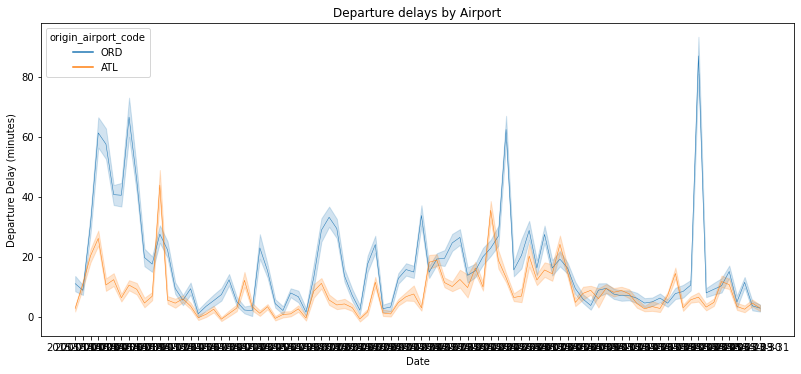

In [0]:
plt.figure(figsize=(13.5,6))
ax = sns.lineplot(data=plot_eda_data, x="dt", y="delay_minutes", hue="origin_airport_code", linewidth = 0.5)
plt.subplots_adjust(top=0.85)
plt.xlabel('Date')
plt.ylabel('Departure Delay (minutes)')
plt.title('Departure delays by Airport')
plt.show()

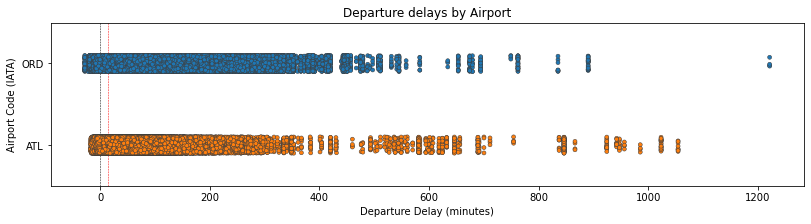

In [0]:
plt.figure(figsize=(13.5,3))
ax = sns.stripplot(data=plot_eda_data, y="origin_airport_code", x="delay_minutes",
                   size = 4,  linewidth = 0.5,  jitter=True)
plt.axvline(x=0, color='k', linestyle='--', linewidth = 0.5)
plt.axvline(x=15, color='r', linestyle='--', linewidth = 0.5)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Airport Code (IATA)')
plt.title('Departure delays by Airport')
plt.show()

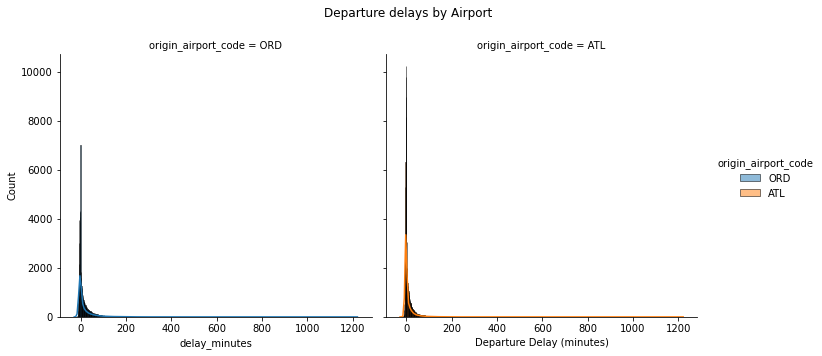

In [0]:
plt.figure(figsize=(13.5,6))
ax = sns.displot(data=plot_eda_data, x="delay_minutes", hue="origin_airport_code", col="origin_airport_code", linewidth = 0.5, kde=True)
plt.xlabel('Departure Delay (minutes)')
plt.subplots_adjust(top=0.85)
plt.suptitle('Departure delays by Airport')
plt.show()

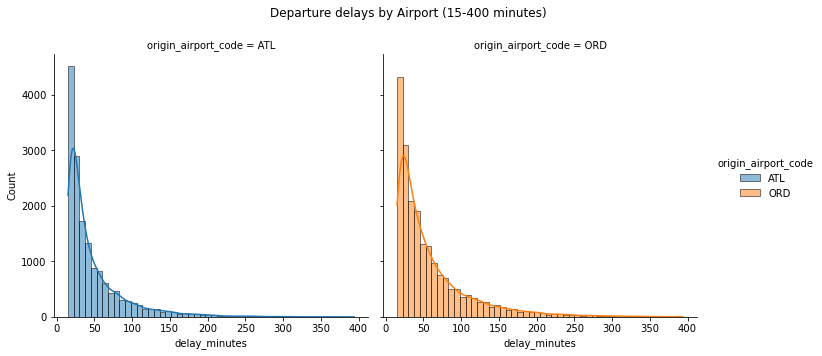

In [0]:
plt.figure(figsize=(13.5,6))
ax = sns.displot(data=plot_cropped_eda_data, x="delay_minutes", hue="origin_airport_code", col="origin_airport_code", bins=50, linewidth = 0.5, kde=True)
plt.subplots_adjust(top=0.85)
plt.suptitle('Departure delays by Airport (15-400 minutes)')
plt.show()

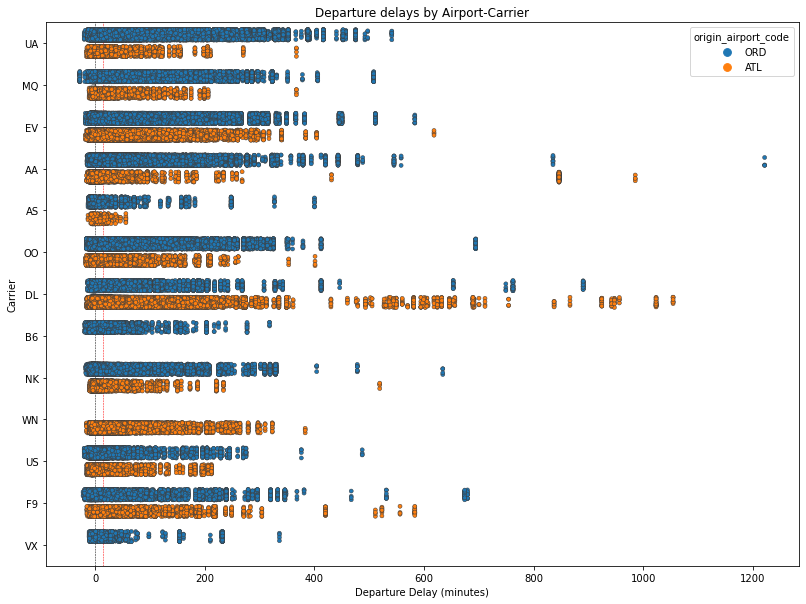

In [0]:
plt.figure(figsize=(13.5,10))
ax = sns.stripplot(data=plot_eda_data, y="carrier", x="delay_minutes",
                   hue="origin_airport_code", hue_order=["ORD", "ATL"], dodge=True,
                   size = 4,  linewidth = 0.5,  jitter=0.25)
plt.axvline(x=0, color='k', linestyle='--', linewidth = 0.5)
plt.axvline(x=15, color='r', linestyle='--', linewidth = 0.5)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Carrier')
plt.title('Departure delays by Airport-Carrier')
plt.show()

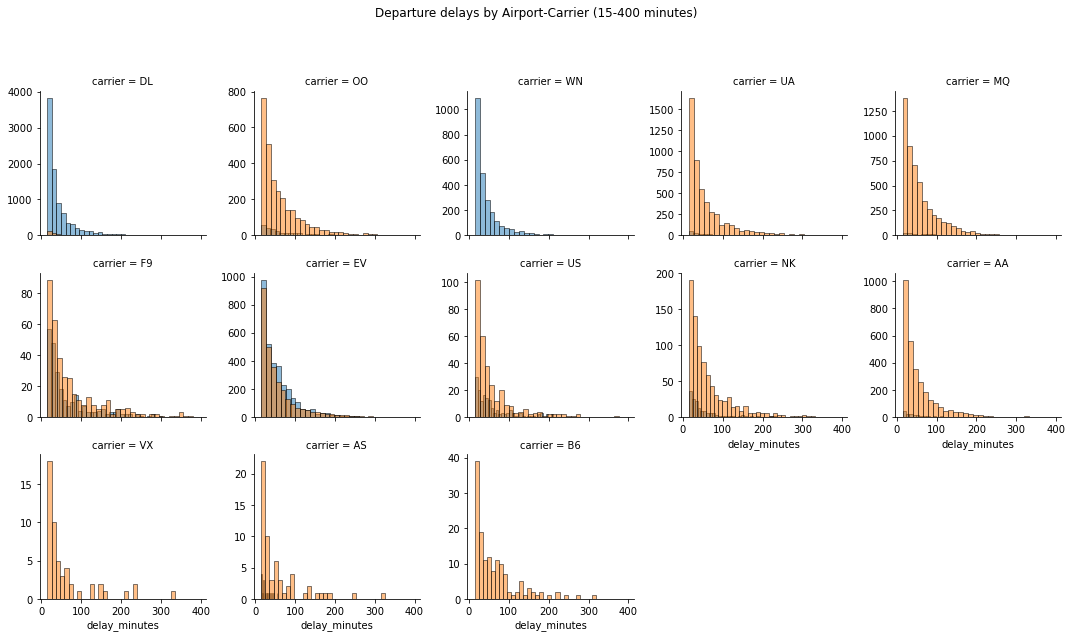

In [0]:
plt.figure(figsize=(13.5,13.5))
ax = sns.FacetGrid(plot_cropped_eda_data,
                   col="carrier",
                   col_wrap=5,
                   hue="origin_airport_code",
                   sharey=False)
ax.map(sns.histplot, "delay_minutes", linewidth=0.5, alpha=.5, bins=30)
plt.subplots_adjust(top=0.85)
plt.suptitle('Departure delays by Airport-Carrier (15-400 minutes)')
plt.show()

In [0]:
hourly_agg = joined_eda.withColumn("hour_of_day", substring('planned_dep_time',1,2))\
        .groupBy('origin_ICAO', 'hour_of_day')\
        .agg(count('dest_ICAO').alias('n_flights'),\
             pyspark_sum('dep_is_delayed').alias('n_delayed'),\
             (pyspark_sum('dep_is_delayed')/count('dep_is_delayed') * 100).alias('pct_origin_dow_delayed'),\
             mean('delay_minutes').alias('mean_origin_dow_delay'))\
        .withColumn("sort_order", concat(col('hour_of_day')).cast(IntegerType()))\
        .orderBy('sort_order', ascending=1)
plot_hourly_agg = hourly_agg.toPandas()

In [0]:
weekly_agg = joined_eda.withColumn("hour_of_day", substring('planned_dep_time',1,2))\
        .groupBy('origin_ICAO', 'day_of_week', 'hour_of_day')\
        .agg(count('dest_ICAO').alias('n_flights'),\
             pyspark_sum('dep_is_delayed').alias('n_delayed'),\
             (pyspark_sum('dep_is_delayed')/count('dep_is_delayed') * 100).alias('pct_origin_dow_delayed'),\
             mean('delay_minutes').alias('mean_origin_dow_delay'))\
        .withColumn("sort_order", concat(col('hour_of_day'), col('day_of_week')).cast(IntegerType()))\
        .orderBy('sort_order', ascending=1)
plot_weekly_agg = weekly_agg.toPandas()

origin_ICAO day_of_week hour_of_day n_flights n_delayed pct_origin_dow_delayed mean_origin_dow_delay sort_order KORD 1 05 1206 388.0 32.172470978441126 13.48424543946932 51 KATL 1 05 270 34.0 12.592592592592592 -1.1962962962962962 51 KORD 2 05 1793 98.0 5.465699944227551 -1.185164528722811 52 KATL 2 05 106 4.0 3.7735849056603774 -5.009433962264151 52 KATL 3 05 84 4.0 4.761904761904762 -5.904761904761905 53 KORD 3 05 799 49.0 6.132665832290362 -0.6495619524405507 53 KATL 4 05 128 13.0 10.15625 -3.9296875 54 KORD 4 05 1388 372.0 26.801152737752158 9.588616714697407 54 KORD 5 05 1586 201.0 12.673392181588902 5.619167717528374 55 KATL 5 05 136 0.0 0.0 -3.823529411764706 55 KORD 6 05 1063 86.0 8.090310442144872 3.141110065851364 56 KATL 6 05 85 4.0 4.705882352941177 -1.588235294117647 56 KORD 7 05 874 146.0 16.704805491990847 2.6315789473684212 57 KATL 7 05 179 139.0 77.6536312849162 26.508379888268156 57 KORD 1 06 5092 2137.0 41.96779261586803 16.643754909662213 61 KATL 1 06 2546 341.0 13.393558523173605 1.4945011783189317 61 KATL 2 06 1259 194.0 15.409054805401112 -0.3113582208101668 62 KORD 2 06 11352 3189.0 28.09196617336152 7.999295278365046 62 KATL 3 06 1064 89.0 8.364661654135338 -2.3477443609022557 63 KORD 3 06 4006 600.0 14.977533699450824 5.523964053919121 63 KATL 4 06 1745 180.0 10.315186246418339 2.438395415472779 64 KORD 4 06 5648 1980.0 35.05665722379604 10.44830028328612 64 KATL 5 06 1205 120.0 9.95850622406639 0.022406639004149378 65 KORD 5 06 7242 2317.0 31.9939243302955 16.74827395747031 65 KATL 6 06 736 92.0 12.5 4.702445652173913 66 KORD 6 06 3231 501.0 15.506035283194059 11.656143608789849 66 KORD 7 06 2619 657.0 25.085910652920962 7.686903398243604 67 KATL 7 06 1683 643.0 38.20558526440879 17.77243018419489 67 KORD 1 07 8881 4096.0 46.120932327440606 39.34669519198288 71 KATL 1 07 8585 751.0 8.747815958066395 3.46592894583576 71 KATL 2 07 6790 1956.0 28.80706921944035 1.909720176730486 72 KORD 2 07 20846 5770.0 27.679171063993092 11.868703828072531 72 KATL 3 07 6248 431.0 6.89820742637644 0.7338348271446863 73 KORD 3 07 8263 1351.0 16.349993948928958 6.9701077090645045 73 KORD 4 07 8489 2482.0 29.237837201083757 12.005536576746378 74 KATL 4 07 10270 1195.0 11.63583252190847 0.6051606621226875 74 KATL 5 07 4437 282.0 6.3556457065584855 1.0962361956276763 75 KORD 5 07 11614 2910.0 25.055966936456002 9.982779404167385 75 KORD 6 07 7053 1457.0 20.65787608110024 7.183042676875089 76 KATL 6 07 2320 243.0 10.474137931034482 1.221551724137931 76 KATL 7 07 4428 833.0 18.812104787714542 6.828139114724481 77 KORD 7 07 6357 1702.0 26.77363536259242 11.425987100833726 77 KATL 1 08 21122 2543.0 12.039579585266546 4.852192027270145 81 KORD 1 08 9450 5816.0 61.544973544973544 51.500952380952384 81 KORD 2 08 20353 8249.0 40.52965164840564 13.859824104554612 82 KATL 2 08 18823 4134.0 21.96249269510705 4.35159113850077 82 KORD 3 08 9707 1937.0 19.95467188626764 8.28742144843927 83 KATL 3 08 12436 1347.0 10.831457060147958 5.329848825989064 83 KATL 4 08 26163 3720.0 14.218552918243322 3.2165653785880823 84 KORD 4 08 10449 4608.0 44.09991386735573 29.155517274380323 84 KORD 5 08 8284 2163.0 26.110574601641716 9.226219217769193 85 KATL 5 08 14206 1833.0 12.902998732929749 5.076728143038153 85 KORD 6 08 8143 2054.0 25.224118875107454 9.415571656637603 86 KATL 6 08 10192 734.0 7.2017268445839875 1.8327119309262165 86 KORD 7 08 7716 2265.0 29.354587869362366 11.013996889580094 87 KATL 7 08 10947 1541.0 14.076916050059376 5.476751621448798 87 KATL 1 09 16989 3009.0 17.711460356701394 7.38660309612102 91 KORD 1 09 7012 4720.0 67.31317741015403 56.51112378779236 91 KORD 2 09 14388 6859.0 47.67167083680845 16.868432026688907 92 KATL 2 09 12292 2409.0 19.598112593556785 7.829075821672633 92 KATL 3 09 7433 841.0 11.314408717879726 3.850935019507601 93 KORD 3 09 8513 2216.0 26.03077645953248 13.647127922001644 93 KORD 4 09 13036 5949.0 45.63516416078552 30.239030377416384 94 KATL 4 09 15994 3049.0 19.063398774540453 7.100912842315869 94 KATL

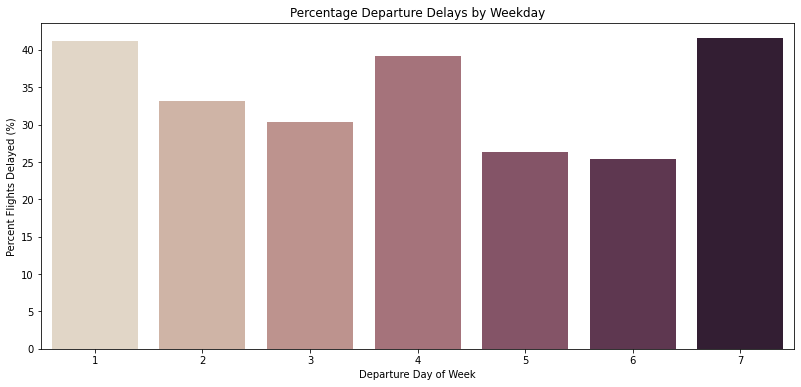

In [0]:
plt.figure(figsize=(13.5,6))
ax = sns.barplot(data=plot_weekly_agg, y="pct_origin_dow_delayed", x="day_of_week",palette="ch:.25",
                 ci=None, linewidth = 0.5)
plt.xlabel('Departure Day of Week')
plt.ylabel('Percent Flights Delayed (%)')
plt.title('Percentage Departure Delays by Weekday')
plt.show()

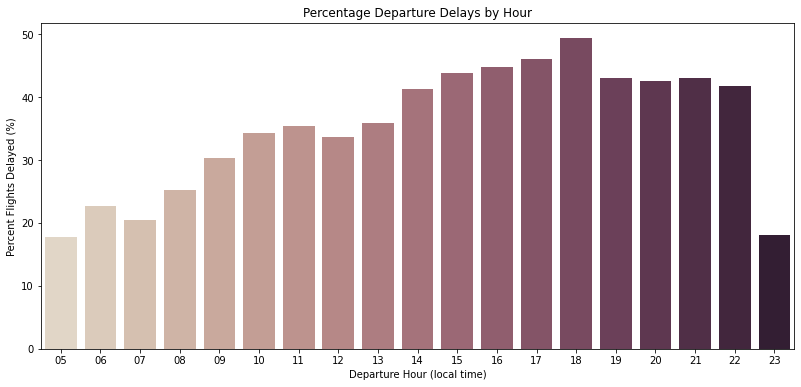

In [0]:
plt.figure(figsize=(13.5,6))
ax = sns.barplot(data=plot_hourly_agg, y="pct_origin_dow_delayed", x="hour_of_day", palette="ch:.25",
                 ci=None, linewidth = 0.5)
plt.xlabel('Departure Hour (local time)')
plt.ylabel('Percent Flights Delayed (%)')
plt.title('Percentage Departure Delays by Hour')
plt.show()

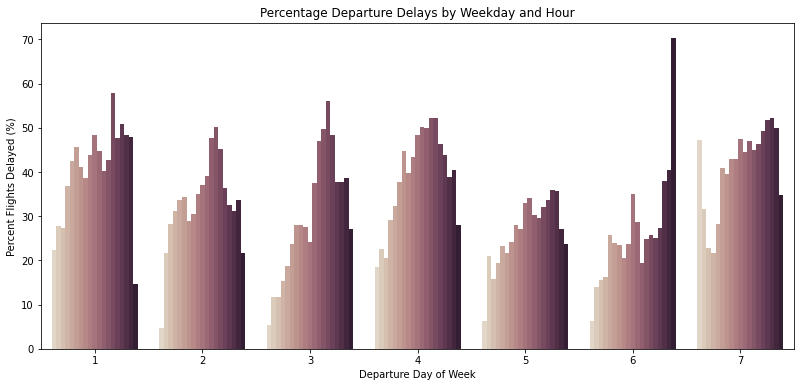

In [0]:
plt.figure(figsize=(13.5,6))
ax = sns.barplot(data=plot_weekly_agg, y="pct_origin_dow_delayed", x="day_of_week",
                 hue='hour_of_day', palette="ch:.25",
                 ci=None, linewidth = 0.5)
ax.legend_.remove()
plt.xlabel('Departure Day of Week')
plt.ylabel('Percent Flights Delayed (%)')
plt.title('Percentage Departure Delays by Weekday and Hour')
plt.show()


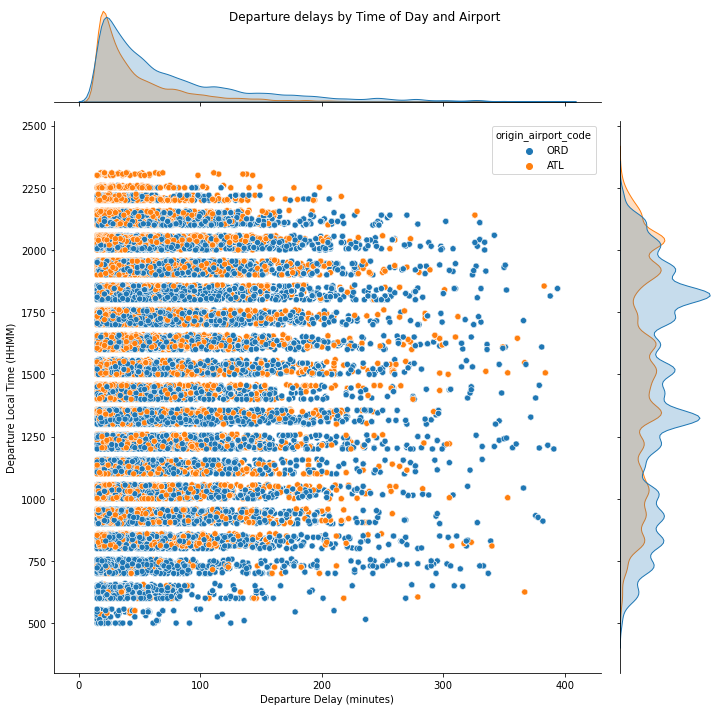

In [0]:
ax = sns.jointplot(data=joined_eda.filter(col("delay_minutes") >= 15).filter(col("delay_minutes") < 400)\
      .withColumn("planned_dep_time", col("planned_dep_time").cast(IntegerType())).toPandas(),
                   y="planned_dep_time", x="delay_minutes", hue="origin_airport_code",
                   height = 10, linewidth = 0.5)
ax.set_axis_labels('Departure Delay (minutes)', 'Departure Local Time (HHMM)')
ax.fig.suptitle('Departure delays by Time of Day and Airport')
plt.show()

## Section 3 - Feature Engineering

In [0]:
# Load Q1 2015 subset if necessary
joined_eda = spark.read.parquet(f"{blob_url}/df_airlines_weather_origin_and_dest_v1/*")

# Load full dataset if necessary
# joined_eda = spark.read.parquet(f"{blob_url}/<>/*")

In [0]:
df_full_airline_stations = spark.read.parquet(f"{blob_url}/full_airlines_stations_v0/*")
df_full_airline_stations.count()

Out[9]: 63493682

In [0]:
df_full_clean = spark.read.parquet(f"{blob_url}/airlines_weather_origin_full_v0/*")
df_full_clean.count()

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-418875703318894> in <module> 
 ----> 1 df_full_clean = spark . read . parquet ( f"{blob_url}/airlines_weather_origin_full_v0/*" ) 
 2 df_full_clean . count ( ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in parquet (self, *paths, **options) 
 483 int96RebaseMode=int96RebaseMode)
 484 
 --> 485 return self . _df ( self . _jreader . parquet ( _to_seq ( self . _spark . _sc , paths ) ) ) 
 486 
 487 def text(self, paths, wholetext=False, lineSep=None, pathGlobFilter=None,

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 114 # Hide where the exception came from that shows a non-Pythonic 
 115 # JVM exception message. 
 --> 116 raise converted from None 
 117 else : 
 118 raise 

 AnalysisException : Path does not exist: wasbs://w261team07container@w261team07storage.blob.core.windows.net/airlines_weather_origin_full_v0/*

### Section 3.1 - Aggregate Features

#### Explore aggregations

In [0]:
def aggregate_keys(df, keys, name, count_only=False):
  if count_only:
    return df.groupBy(keys).agg(count('index_id').alias(f"n_flights_{name}"))
  
  else:
    return df.groupBy(keys).agg(count('index_id').alias(f"n_flights_{name}"),\
                                count(when(col("dep_is_delayed"), col("dep_is_delayed"))).alias(f"n_delayed_{name}"),\
                                (count(when(col("dep_is_delayed"), col("dep_is_delayed")))/count('dep_is_delayed') * 100).alias(f"pct_delayed_{name}"),\
                                mean('delay_minutes').alias(f"mean_delay_{name}"))

In [0]:
# origin aggregates
agg_origin = aggregate_keys(joined_eda,
                            ['origin_ICAO'],
                            'from_origin')
display(agg_origin)

# dest aggregates
agg_dest = aggregate_keys(joined_eda,
                          ['dest_ICAO'],
                          'to_dest')
display(agg_dest)

# route (origin + destination) aggregates
agg_route = aggregate_keys(joined_eda,
                           ['origin_ICAO',
                           'dest_ICAO',
                           'origin_longitude',
                           'origin_latitude',
                           'dest_longitude',
                           'dest_latitude'],
                           'for_route')
display(agg_route)

# state aggregates
agg_origin_state = aggregate_keys(joined_eda,
                           ['origin_state'],
                           'from_state')
display(agg_origin_state)
agg_dest_state = aggregate_keys(joined_eda,
                         ['dest_state'],
                         'to_state')
display(agg_dest_state)


origin_ICAO n_flights_from_origin n_delayed_from_origin pct_delayed_from_origin mean_delay_from_origin KATL 89632 17365.0 19.373661192431275 8.350087022491968 KORD 71425 24202.0 33.88449422471124 17.046538326916345

dest_ICAO n_flights_to_dest n_delayed_to_dest pct_delayed_to_dest mean_delay_to_dest KAVP 183 58.0 31.693989071038253 11.655737704918034 KATL 1534 435.0 28.357235984354627 17.8767926988266 KGRR 1054 283.0 26.85009487666034 12.121442125237191 KMHT 141 34.0 24.113475177304963 13.0 KMSP 2785 724.0 25.99640933572711 14.491921005385997 KMSY 1732 335.0 19.341801385681293 9.334295612009237 KMGM 580 109.0 18.79310344827586 8.23793103448276 KPSP 188 41.0 21.808510638297875 12.76063829787234 PHOG 31 9.0 29.03225806451613 26.387096774193548 KFAR 545 180.0 33.02752293577982 15.486238532110091 KBTR 677 174.0 25.70162481536189 14.738552437223042 PANC 59 31.0 52.54237288135594 31.847457627118644 KAVL 620 124.0 20.0 10.269354838709678 KGRK 164 53.0 32.31707317073171 15.926829268292684 KOAK 92 20.0 21.73913043478261 7.554347826086956 KDAY 1077 295.0 27.390900649953576 10.209842154131847 KSJC 166 46.0 27.710843373493976 14.41566265060241 KSHV 507 113.0 22.287968441814595 8.309664694280078 KFSD 641 208.0 32.44929797191888 14.252730109204368 KERI 172 41.0 23.837209302325583 11.55813953488372 KCMI 491 198.0 40.32586558044807 17.386965376782076 KBZN 85 27.0 31.76470588235294 12.670588235294117 KAUS 1259 306.0 24.305003971405878 11.756155679110405 KCAK 857 183.0 21.353558926487747 11.050175029171529 KDAB 397 62.0 15.617128463476071 6.08816120906801 KSTC 82 34.0 41.46341463414634 18.28048780487805 KGRB 868 251.0 28.91705069124424 12.65668202764977 KBQK 243 44.0 18.106995884773664 8.925925925925926 KEVV 595 195.0 32.773109243697476 13.647058823529411 KCLE 1842 518.0 28.121606948968513 15.582519001085776 KELP 257 67.0 26.07003891050584 13.198443579766536 KBWI 1867 493.0 26.40599892876272 12.121049812533476 KPVD 407 104.0 25.552825552825553 8.45945945945946 KASE 447 154.0 34.45190156599553 18.859060402684563 KPAH 179 49.0 27.37430167597765 10.128491620111731 KHSV 780 177.0 22.692307692307693 9.03974358974359 KRST 440 170.0 38.63636363636363 15.702272727272728 KPHF 389 85.0 21.85089974293059 7.616966580976864 KECP 518 108.0 20.84942084942085 10.17953667953668 KMTJ 119 40.0 33.61344537815126 17.84873949579832 KXNA 1072 352.0 32.83582089552239 16.411380597014926 KDCA 3176 795.0 25.031486146095716 10.134130982367758 KOAJ 308 59.0 19.155844155844157 9.805194805194805 KBMI 482 159.0 32.98755186721991 14.578838174273859 KMLB 348 54.0 15.517241379310345 5.304597701149425 KILM 428 69.0 16.121495327102803 7.154205607476635 KSPI 270 87.0 32.22222222222222 13.92962962962963 KDEN 2675 821.0 30.69158878504673 17.9996261682243 KCRW 419 115.0 27.44630071599045 14.8090692124105 KOKC 887 261.0 29.4250281848929 14.17249154453213 TIST 223 30.0 13.452914798206278 5.031390134529148 KCLT 3052 561.0 18.381389252948885 7.013433813892529 KTTN 81 18.0 22.22222222222222 8.407407407407407 KMIA 2516 541.0 21.502384737678856 10.111287758346581 KEYW 419 61.0 14.558472553699284 8.536992840095465 KBOI 95 48.0 50.526315789473685 26.473684210526315 KRDU 1612 340.0 21.09181141439206 8.598014888337469 KIAD 1280 345.0 26.953125 15.7453125 KCAE 865 171.0 19.76878612716763 9.252023121387284 KRSW 1781 383.0 21.50477259966311 10.294216732172936 KLEX 1032 249.0 24.12790697674419 10.853682170542635 KBNA 1665 477.0 28.64864864864865 15.571171171171171 KMOB 659 132.0 20.030349013657055 9.072837632776935 KSEA 1320 317.0 24.015151515151516 12.093181818181819 KMDW 1167 236.0 20.22279348757498 8.113967437874892 KLNK 380 104.0 27.368421052631582 12.126315789473685 KLAN 234 60.0 25.64102564102564 10.324786324786325 KTPA 2519 591.0 23.461691147280668 11.246129416435092 KABY 245 52.0 21.224489795918366 9.159183673469387 KABQ 252 59.0 23.41269841269841 11.726190476190476 KLIT 1018 313.0 30.746561886051083 14.304518664047151 KDAL 736 166.0 22.554347826086957 8.591032608695652 KMLU 330 76.0 23.03030303030303 8.463636363636363 KFSM 235 46.0 19.574468085106382 9.651063829787233 KLSE 305 112.0 36.721311475409834 16.845901639344262 KCMX 177 55.0 31.07344632768362 8.451977401129943 KIND 1734 428.0 24.68281430219146

origin_ICAO dest_ICAO origin_longitude origin_latitude dest_longitude dest_latitude n_flights_for_route n_delayed_for_route pct_delayed_for_route mean_delay_for_route KATL KBDL -84.428101 33.6367 -72.68319702149999 41.9388999939 742 151.0 20.350404312668463 7.129380053908355 KATL KJFK -84.428101 33.6367 -73.77890015 40.63980103 449 145.0 32.29398663697104 19.031180400890868 KATL KORD -84.428101 33.6367 -87.9048 41.9786 1547 402.0 25.9857789269554 13.273432449903039 KORD KDAY -87.9048 41.9786 -84.21939849853516 39.902400970458984 718 232.0 32.31197771587744 11.805013927576601 KATL KGRR -84.428101 33.6367 -85.52279663 42.88079834 348 41.0 11.781609195402298 4.836206896551724 KORD KOKC -87.9048 41.9786 -97.60070037841797 35.39310073852539 372 166.0 44.623655913978496 24.043010752688172 KORD KTVC -87.9048 41.9786 -85.58219909667969 44.74140167236328 487 165.0 33.880903490759756 15.04517453798768 KORD KSAW -87.9048 41.9786 -87.395401001 46.353599548300004 77 31.0 40.25974025974026 22.532467532467532 KORD KBDL -87.9048 41.9786 -72.68319702149999 41.9388999939 296 113.0 38.17567567567568 17.5472972972973 KORD KDCA -87.9048 41.9786 -77.037697 38.8521 1491 449.0 30.1140174379611 13.140174379610999 KORD KABQ -87.9048 41.9786 -106.609001 35.040199 87 35.0 40.229885057471265 20.655172413793103 KORD KIAH -87.9048 41.9786 -95.34140014648438 29.984399795532227 1026 409.0 39.863547758284604 22.922027290448344 KATL KLAX -84.428101 33.6367 -118.4079971 33.94250107 1221 267.0 21.867321867321866 10.484029484029485 KORD KRST -87.9048 41.9786 -92.5 43.90829849243164 354 151.0 42.65536723163842 17.624293785310734 KORD KASE -87.9048 41.9786 -106.8690033 39.22320175 359 130.0 36.211699164345404 20.39275766016713 KORD KTYS -87.9048 41.9786 -83.9940033 35.81100082 526 183.0 34.79087452471482 16.844106463878326 KORD KDSM -87.9048 41.9786 -93.66310119628906 41.534000396728516 946 360.0 38.05496828752643 18.28435517970402 KATL KEWN -84.428101 33.6367 -77.04290008539999 35.0730018616 157 33.0 21.019108280254777 5.656050955414012 KATL KAVL -84.428101 33.6367 -82.54180145263672 35.43619918823242 500 82.0 16.400000000000002 6.288 KORD KSAT -87.9048 41.9786 -98.46980285644531 29.533700942993164 255 107.0 41.96078431372549 25.478431372549018 KORD KIND -87.9048 41.9786 -86.294403 39.7173 754 245.0 32.49336870026525 14.563660477453581 KATL KGNV -84.428101 33.6367 -82.2717971802 29.6900997162 538 114.0 21.189591078066915 9.869888475836431 KORD KPHL -87.9048 41.9786 -75.24109649658203 39.87189865112305 1004 300.0 29.880478087649404 12.643426294820717 KATL KRST -84.428101 33.6367 -92.5 43.90829849243164 86 19.0 22.093023255813954 7.790697674418604 KATL KMBS -84.428101 33.6367 -84.07959747314453 43.532901763916016 11 2.0 18.181818181818183 20.272727272727273 KATL KMEM -84.428101 33.6367 -89.97669982910156 35.04240036010742 820 158.0 19.26829268292683 6.6085365853658535 KATL KMTJ -84.428101 33.6367 -107.893997192 38.509799957300004 23 5.0 21.73913043478261 6.565217391304348 KATL KLNK -84.428101 33.6367 -96.75920104980469 40.85100173950195 88 30.0 34.090909090909086 13.318181818181818 KATL KIND -84.428101 33.6367 -86.294403 39.7173 980 183.0 18.6734693877551 8.095918367346938 KATL KBTV -84.428101 33.6367 -73.15329742429999 44.471900939899996 90 29.0 32.22222222222222 19.955555555555556 KORD KELM -87.9048 41.9786 -76.8916015625 42.1599006652832 166 59.0 35.54216867469879 15.91566265060241 KORD KMKE -87.9048 41.9786 -87.89659881591797 42.947200775146484 1287 437.0 33.95493395493395 17.37839937839938 KATL KCRW -84.428101 33.6367 -81.59320068359375 38.37310028076172 302 76.0 25.165562913907287 14.841059602649006 KATL KDAL -84.428101 33.6367 -96.851799 32.847099 736 166.0 22.554347826086957 8.591032608695652 KORD KSFO -87.9048 41.9786 -122.375 37.61899948120117 1521 601.0 39.513477975016436 22.85207100591716 KORD KDEN -87.9048 41.9786 -104.672996521 39.861698150635 1474 542.0 36.77069199457259 23.145861601085482 KATL KAEX -84.428101 33.6367 -92.54979705810547 31.327400207519

origin_state n_flights_from_state n_delayed_from_state pct_delayed_from_state mean_delay_from_state IL 71425 24202.0 33.88449422471124 17.046538326916345 GA 89632 17365.0 19.373661192431275 8.350087022491968

dest_state n_flights_to_state n_delayed_to_state pct_delayed_to_state mean_delay_to_state SC 2982 540.0 18.10865191146881 8.2719651240778 AZ 2645 604.0 22.83553875236295 11.790926275992438 LA 3864 825.0 21.350931677018632 9.936335403726709 MN 3577 1005.0 28.096169974839253 14.348616158792284 NJ 2303 725.0 31.48067737733391 16.066435084672168 OR 586 150.0 25.597269624573375 13.271331058020477 VA 8050 2000.0 24.84472049689441 11.015031055900621 RI 407 104.0 25.552825552825553 8.45945945945946 KY 3809 972.0 25.518508794959306 11.219217642425834 WY 142 38.0 26.76056338028169 11.140845070422536 NH 141 34.0 24.113475177304963 13.0 MI 6273 1778.0 28.343695201657898 12.519368723098996 NV 2072 551.0 26.59266409266409 13.384169884169884 WI 5544 1613.0 29.094516594516595 13.031746031746032 ID 95 48.0 50.526315789473685 26.473684210526315 CA 7892 2263.0 28.674607197161684 15.125950329447543 CT 1038 264.0 25.43352601156069 10.10019267822736 NE 1289 332.0 25.756400310318078 11.385570209464701 MT 100 30.0 30.0 11.93 NC 7388 1415.0 19.15268002165674 8.061315646995126 VT 136 44.0 32.35294117647059 19.566176470588236 MD 1867 493.0 26.40599892876272 12.121049812533476 MO 3957 1059.0 26.762699014404852 12.87465251453121 VI 236 32.0 13.559322033898304 4.991525423728813 IL 5437 1524.0 28.03016369321317 12.201949604561339 ME 119 26.0 21.84873949579832 11.949579831932773 WA 1320 317.0 24.015151515151516 12.093181818181819 ND 635 208.0 32.75590551181102 15.080314960629922 MS 1392 268.0 19.25287356321839 8.371408045977011 AL 3398 709.0 20.865214832254267 8.728075338434373 IN 3804 1075.0 28.259726603575185 12.470820189274448 OH 5832 1634.0 28.017832647462278 13.66358024691358 TN 5317 1375.0 25.860447620838816 11.836561971036298 IA 2824 1008.0 35.69405099150141 17.075779036827196 NM 252 59.0 23.41269841269841 11.726190476190476 PA 5447 1372.0 25.18817697815311 10.95961079493299 SD 649 211.0 32.5115562403698 14.285053929121725 NY 8970 2944.0 32.82051282051282 14.910813823857302 TX 10496 2584.0 24.61890243902439 12.452172256097562 WV 419 115.0 27.44630071599045 14.8090692124105 GA 4071 895.0 21.984770326701057 12.262589044460821 MA 2636 857.0 32.5113808801214 13.042109256449166 KS 988 315.0 31.88259109311741 16.986842105263158 CO 3833 1192.0 31.098356378815552 18.240803548134622 FL 20364 4155.0 20.40365350618739 9.466411314083677 AK 59 31.0 52.54237288135594 31.847457627118644 AR 2325 711.0 30.58064516129032 14.805591397849462 OK 1845 505.0 27.371273712737125 12.876422764227643 PR 723 151.0 20.885200553250346 11.002766251728907 UT 1298 350.0 26.964560862865948 17.191833590138675 HI 211 57.0 27.014218009478675 19.27962085308057

FILL OUT: Narrative

In [0]:
def plot_map(routes, crop_to_usa=True, dataset_name=''):
  # extract values
  orig_lon = [float(row['origin_longitude']) for row in routes]
  orig_lat = [float(row['origin_latitude']) for row in routes]
  dest_lon = [float(row['dest_longitude']) for row in routes]
  dest_lat = [float(row['dest_latitude']) for row in routes]
  n_flights = [float(row['n_flights_for_route']) for row in routes]
  
  # normalize flights
  n_min = min(n_flights)
  n_max = max(n_flights)
  n_flights_normalized = [(x-n_min)/(n_max-n_min) for x in n_flights]

  # create gradient
  g = Gradient(((0, 0, 0, 0), (0.5, 0, 204, 85), (1, 205, 255, 204)))

  # initialize GCMapper and set data
  gcm = GCMapper(cols=g, height=8000, width=16000)
  gcm.set_data(orig_lon,
               orig_lat,
               dest_lon,
               dest_lat,
               n_flights_normalized)
  # draw image
  img = gcm.draw()

  # plot
  plt.figure(figsize=(13.5, 10))
  plt.axis('off')
  plt.title(f"Flight routes - {dataset_name}")
  if crop_to_usa:
    plt.imshow(img.crop((600, 800, 5500, 3500)))
  else:
    plt.imshow(img)
  plt.show()

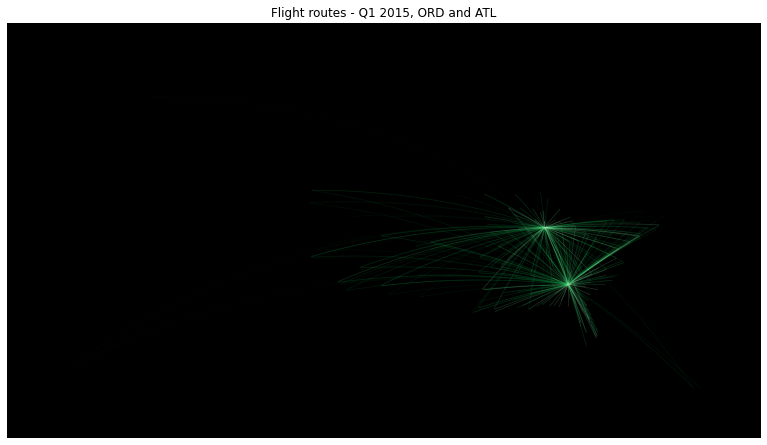

In [0]:
plot_map(agg_route.collect(),
         dataset_name='Q1 2015, ORD and ATL')

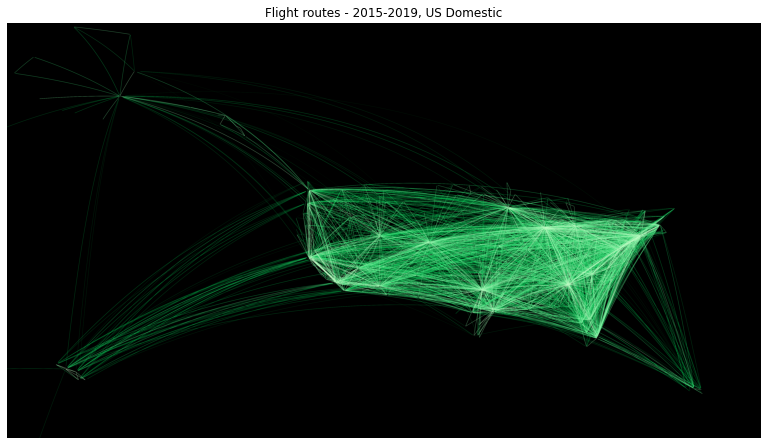

In [0]:
plot_map(aggregate_keys(df_airlines_full_clean,
                        ['origin_ICAO',
                        'dest_ICAO',
                        'origin_longitude',
                        'origin_latitude',
                        'dest_longitude',
                        'dest_latitude'],
                        'for_route',
                        count_only=True).filter(col("origin_ICAO").isNotNull() & col("dest_ICAO").isNotNull()).collect(),
         dataset_name='2015-2019, US Domestic')

#### Join features

In [0]:
def join_aggs(df, origin, dest, route, o_state, d_state):
  joined = df.alias('d').join(origin.alias('o'),
                              (col("d.origin_ICAO") == col("o.origin_ICAO")),
                              'left')\
                        .join(dest.alias('de'),
                              (col("d.dest_ICAO") == col("de.dest_ICAO")),
                              'left')\
                        .join(route.alias('r'),
                              (col("d.origin_ICAO") == col("r.origin_ICAO")) &\
                              (col("d.dest_ICAO") == col("r.dest_ICAO")),
                              'left')\
                        .join(o_state.alias('os'),
                              (col("d.origin_state") == col("os.origin_state")),
                              'left')\
                        .join(d_state.alias('ds'),
                              (col("d.dest_state") == col("ds.dest_state")),
                              'left')\
                        .select('d.*',
                                'o.pct_delayed_from_origin',
                                'o.mean_delay_from_origin',
                                'de.pct_delayed_to_dest',
                                'de.mean_delay_to_dest',
                                'r.pct_delayed_for_route',
                                'r.mean_delay_for_route',
                                'os.pct_delayed_from_state',
                                'os.mean_delay_from_state',
                                'ds.pct_delayed_to_state',
                                'ds.mean_delay_to_state'
                                )\
                        .orderBy(col("index_id").asc())
  return joined

In [0]:
# join
eda_with_aggs = join_aggs(joined_eda, agg_origin, agg_dest, agg_route, agg_origin_state, agg_dest_state)

# write
eda_with_aggs.write.mode('overwrite').parquet(f"{blob_url}/eda_with_aggs_v1")

In [0]:
eda_with_aggs = spark.read.parquet(f"{blob_url}/eda_with_aggs_v1/*")
display(eda_with_aggs)

origin_ICAO origin_utc_offset origin_timezone origin_latitude origin_longitude origin_altitude dest_ICAO dest_utc_offset dest_timezone dest_latitude dest_longitude dest_altitude index_id year quarter month day_of_month day_of_week dt carrier tail_num flight_num origin_state origin_city origin_airport_id origin_airport_code dest_state dest_city dest_airport_id dest_airport_code planned_dep_time actual_dep_time delay_minutes dep_is_delayed dep_delay_group dep_hour actual_arr_time arr_delay_minutes arr_delay_group arr_hour canceled cancel_code is_diverted planned_duration actual_duration num_flights flight_distance distance_group carrier_delay weather_delay nas_delay security_delay late_aircraft_delay div_reached_dest planned_departure_utc time_at_prediction_utc origin_station_id dest_station_id origin_wnd_angle origin_wnd_angle_qc origin_wnd_type origin_wnd_speed origin_wnd_speed_qc origin_cig_cloud_agl origin_cig_cloud_agl_qc origin_cig_method origin_cig_cavok origin_vis_dist origin_vis_dist_qc origin_vis_var origin_vis_var_qc origin_tmp_c origin_tmp_qc origin_dew_c origin_dew_qc origin_slp_p origin_slp_qc origin_weather_offset_minutes dest_wnd_angle dest_wnd_angle_qc dest_wnd_type dest_wnd_speed dest_wnd_speed_qc dest_cig_cloud_agl dest_cig_cloud_agl_qc dest_cig_method dest_cig_cavok dest_vis_dist dest_vis_dist_qc dest_vis_var dest_vis_var_qc dest_tmp_c dest_tmp_qc dest_dew_c dest_dew_qc dest_slp_p dest_slp_qc dest_weather_offset_minutes pct_delayed_from_origin mean_delay_from_origin pct_delayed_to_dest mean_delay_to_dest pct_delayed_for_route mean_delay_for_route pct_delayed_from_state mean_delay_from_state pct_delayed_to_state mean_delay_to_state KATL -5 America/New_York 33.6367 -84.428101 1026 KDAY -5 America/New_York 39.902400970458984 -84.21939849853516 1009 157040 2015 1 3 29 7 2015-03-29 DL N928DL 2306 GA Atlanta, GA 10397 ATL OH Dayton, OH 11267 DAY 2150 2203 13.0 0.0 0 2100-2159 2331 5.0 0 2300-2359 0.0 null 0.0 96.0 88.0 1.0 432.0 2 null null null null null null 2015-03-30T01:50:00.000+0000 2015-03-29T23:50:00.000+0000 72219013874 72429093815 180 5 N 31 5 1829 5 M N 16093 5 N 5 156 5 -44 5 10242 5 -58.0 190 5 N 57 5 2286 5 M N 16093 5 N 5 83 5 -83 5 10152 5 -54.0 19.373661192431275 8.350087022491968 27.390900649953576 10.209842154131847 17.548746518105848 7.0194986072423395 19.373661192431275 8.350087022491968 28.017832647462278 13.66358024691358 KATL -5 America/New_York 33.6367 -84.428101 1026 KDAB -5 America/New_York 29.179899 -81.058098 34 157041 2015 1 3 29 7 2015-03-29 DL N678DL 2587 GA Atlanta, GA 10397 ATL FL Daytona Beach, FL 11252 DAB 2204 2204 0.0 0.0 0 2200-2259 2311 -17.0 -2 2300-2359 0.0 null 0.0 84.0 67.0 1.0 366.0 2 null null null null null null 2015-03-30T02:04:00.000+0000 2015-03-30T00:04:00.000+0000 72219013874 74787012834 170 1 N 31 1 null 9 9 N 16000 1 9 9 150 1 -44 1 10242 1 -4.0 010 5 N 31 5 22000 5 9 N 16093 5 N 5 139 5 22 5 10278 5 -11.0 19.373661192431275 8.350087022491968 15.617128463476071 6.08816120906801 15.617128463476071 6.08816120906801 19.373661192431275 8.350087022491968 20.40365350618739 9.466411314083677 KATL -5 America/New_York 33.6367 -84.428101 1026 KSRQ -5 America/New_York 27.39539909362793 -82.55439758300781 30 157042 2015 1 3 29 7 2015-03-29 DL N690DL 776 GA Atlanta, GA 10397 ATL FL Sarasota/Bradenton, FL 14986 SRQ 2202 2204 2.0 0.0 0 2200-2259 2328 -7.0 -1 2300-2359 0.0 null 0.0 93.0 84.0 1.0 444.0 2 null null null null null null 2015-03-30T02:02:00.000+0000 2015-03-30T00:02:00.000+0000 72219013874 72211512871 170 1 N 31 1 null 9 9 N 16000 1 9 9 150 1 -44 1 10242 1 -2.0 300 5 N 36 5 22000 5 9 N 16093 5 N 5 178 5 94 5 10248 5 -9.0 19.373661192431275 8.350087022491968 15.758468335787922 6.75699558173785 12.13768115942029 4.523550724637682 19.373661192431275 8.350087022491968 20.40365350618739 9.466411314083677 KATL -5 America/New_York 33.6367 -84.428101 1026 KTPA -5 America/New_York 27.975500106811523 -82.533203125 26 157043 2015 1 3 29 7 2015-03-29 WN N760SW 1437 GA Atlanta, 

In [0]:
full_join_2015  = spark.read.parquet(f"{blob_url}/full_join_2015_v0/*").cache()

# origin aggregates
agg_origin = aggregate_keys(full_join_2015,
                            ['origin_ICAO'],
                            'from_origin')
display(agg_origin)

# dest aggregates
agg_dest = aggregate_keys(full_join_2015,
                          ['dest_ICAO'],
                          'to_dest')
display(agg_dest)

# route (origin + destination) aggregates
agg_route = aggregate_keys(full_join_2015,
                           ['origin_ICAO',
                           'dest_ICAO',
                           'origin_longitude',
                           'origin_latitude',
                           'dest_longitude',
                           'dest_latitude'],
                           'for_route')
display(agg_route)

# state aggregates
agg_origin_state = aggregate_keys(full_join_2015,
                           ['origin_state'],
                           'from_state')
display(agg_origin_state)
agg_dest_state = aggregate_keys(full_join_2015,
                         ['dest_state'],
                         'to_state')

# join
full_2015_with_aggs = join_aggs(full_join_2015, agg_origin, agg_dest, agg_route, agg_origin_state, agg_dest_state)

# write
full_2015_with_aggs.write.mode('overwrite').parquet(f"{blob_url}/full_2015_with_aggs_v0")


In [0]:
full_join  = spark.read.parquet(f"{blob_url}/full_join_2015_v0/*")\
             .union(spark.read.parquet(f"{blob_url}/full_join_2016_v0/*"))\
             .union(spark.read.parquet(f"{blob_url}/full_join_2017_v0/*"))\
             .union(spark.read.parquet(f"{blob_url}/full_join_2018_v0/*"))\
             .union(spark.read.parquet(f"{blob_url}/full_join_2019_v0/*")).cache()

# origin aggregates
agg_origin = aggregate_keys(full_join,
                            ['origin_ICAO'],
                            'from_origin')

# dest aggregates
agg_dest = aggregate_keys(full_join,
                          ['dest_ICAO'],
                          'to_dest')

# route (origin + destination) aggregates
agg_route = aggregate_keys(full_join,
                           ['origin_ICAO',
                           'dest_ICAO',
                           'origin_longitude',
                           'origin_latitude',
                           'dest_longitude',
                           'dest_latitude'],
                           'for_route')

# state aggregates
agg_origin_state = aggregate_keys(full_join,
                           ['origin_state'],
                           'from_state')
agg_dest_state = aggregate_keys(full_join,
                         ['dest_state'],
                         'to_state')

# join
full_join_with_aggs = join_aggs(full_join, agg_origin, agg_dest, agg_route, agg_origin_state, agg_dest_state)

# write
full_join_with_aggs.write.mode('overwrite').parquet(f"{blob_url}/full_join_with_aggs_v0")


In [0]:
df_airlines_full = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*")
print(f"The raw airlines dataset contains {df_airlines_full.count()} records, with {len(df_airlines_full.columns)} columns.")

The raw airlines dataset contains 63493682 records, with 109 columns.

In [0]:
full_no_duplicates = df_airlines_full.dropDuplicates(['FL_DATE', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME'])
print(f"After dropping duplicates, the raw airlines dataset contains {full_no_duplicates.count()} records, with {len(full_no_duplicates.columns)} columns.")
display(full_no_duplicates.limit(10))

After dropping duplicates, the raw airlines dataset contains 31746726 records, with 109 columns.

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 2015 1 1 1 4 2015-01-01 UA 19977 UA null 215 11292 1129202 30325 DEN Denver, CO CO 8 Colorado 82 13487 1348702 31650 MSP Minneapolis, MN MN 27 Minnesota 63 1953 null null null null null 1900-1959 null null null null 2249 null null null null null 2200-2259 1.0 B 0.0 116.0 null null 1.0 680.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 1 1 4 2015-01-01 UA 19977 UA null 453 11292 1129202 30325 DEN Denver, CO CO 8 Colorado 82 10713 1071302 30713 BOI Boise, ID ID 16 Idaho 83 1901 null null null null null 1900-1959 null null null null 2102 null null null null null 2100-2159 1.0 B 0.0 121.0 null null 1.0 649.0 3 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 1 1 4 2015-01-01 UA 19977 UA null 470 12173 1217302 32134 HNL Honolulu, HI HI 15 Hawaii 2 12892 1289203 32575 LAX Los Angeles, CA CA 6 California 91 2358 null null null null null 2300-2359 null null null null 733 null null null null null 0700-0759 1.0 A 0.0 335.0 null null 1.0 2556.0 11 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 1 1 4 2015-01-01 US 20355 US null 523 15016 1501603 31123 STL St. Louis, MO MO 29 Missouri 64 14107 1410702 30466 PHX Phoenix, AZ AZ 4 Arizona 81 1430 null null null null null 1400-1459 null null null null 1656 null null null null null 1600-1659 1.0 A 0.0 206.0 null null 1.0 1262.0 6 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 1 1 1 4 2015-01-01 US 20355 US null 555 14100 1410002 34100 PHL Philadelphia, PA PA 42 Pennsylvania 23 14869 1486903 34614 SLC Salt Lake City, UT UT 49 Utah 87 1810 null null null null null 

In [0]:
full_join_with_aggs = spark.read.parquet(f"{blob_url}/full_join_with_aggs_v0/*")
print(f"The fully joined dataset contains {full_join_with_aggs.count()} records, with {len(full_join_with_aggs.columns)} columns.")
display(full_join_with_aggs.limit(10))

The fully joined dataset contains 63490770 records, with 88 columns.

index_id origin_ICAO origin_utc_offset origin_timezone origin_latitude origin_longitude origin_altitude dest_ICAO dest_utc_offset dest_timezone dest_latitude dest_longitude dest_altitude year quarter month day_of_month day_of_week dt carrier tail_num flight_num origin_state origin_city origin_airport_id origin_airport_code dest_state dest_city dest_airport_id dest_airport_code planned_dep_time actual_dep_time delay_minutes dep_is_delayed dep_delay_group dep_hour actual_arr_time arr_delay_minutes arr_delay_group arr_hour canceled cancel_code is_diverted planned_duration actual_duration num_flights flight_distance distance_group carrier_delay weather_delay nas_delay security_delay late_aircraft_delay div_reached_dest planned_departure_utc time_at_prediction_utc origin_station_id dest_station_id origin_wnd_angle origin_wnd_angle_qc origin_wnd_type origin_wnd_speed origin_wnd_speed_qc origin_cig_cloud_agl origin_cig_cloud_agl_qc origin_cig_method origin_cig_cavok origin_vis_dist origin_vis_dist_qc origin_vis_var origin_vis_var_qc origin_tmp_c origin_tmp_qc origin_dew_c origin_dew_qc origin_slp_p origin_slp_qc origin_weather_offset_minutes pct_delayed_from_origin mean_delay_from_origin pct_delayed_to_dest mean_delay_to_dest pct_delayed_for_route mean_delay_for_route pct_delayed_from_state mean_delay_from_state pct_delayed_to_state mean_delay_to_state 50469992 KCLT -5 America/New_York 35.2140007019043 -80.94309997558594 748 KHSV -6 America/Chicago 34.637199401855 -86.775100708008 629 2019 1 2 18 1 2019-02-18 OH N502AE 5566 NC Charlotte, NC 11057 CLT AL Huntsville, AL 12217 HSV 1338 1328 -10.0 false -1 1300-1359 1407 -1.0 -1 1400-1459 false null false 90.0 99.0 1.0 333.0 2 null null null null null null 2019-02-18T18:38:00.000+0000 2019-02-18T16:38:00.000+0000 72314013881 72323003856 300 5 N 31 5 22000 5 9 N 16093 5 N 5 128 5 78 5 10185 5 -46.0 19.503349883352275 9.450596899611206 17.86686305273606 8.283615059546676 20.876826722338205 9.584899095337509 19.55165808123057 9.860482839452256 19.79700668691441 9.749932309596565 50469993 KCLT -5 America/New_York 35.2140007019043 -80.94309997558594 748 KFLL -5 America/New_York 26.072599 -80.152702 9 2019 1 2 18 1 2019-02-18 AA N652AW 523 NC Charlotte, NC 11057 CLT FL Fort Lauderdale, FL 11697 FLL 1329 1328 -1.0 false -1 1300-1359 1522 -10.0 -1 1500-1559 false null false 123.0 114.0 1.0 632.0 3 null null null null null null 2019-02-18T18:29:00.000+0000 2019-02-18T16:29:00.000+0000 72314013881 74783012849 300 5 N 31 5 22000 5 9 N 16093 5 N 5 128 5 78 5 10185 5 -37.0 19.503349883352275 9.450596899611206 22.13976416997056 11.883598720791595 17.927606027652633 7.962715550722386 19.55165808123057 9.860482839452256 20.265895898289283 10.53228037685095 50469994 KCLT -5 America/New_York 35.2140007019043 -80.94309997558594 748 KFLL -5 America/New_York 26.072599 -80.152702 9 2019 1 2 18 1 2019-02-18 AA N652AW 523 NC Charlotte, NC 11057 CLT FL Fort Lauderdale, FL 11697 FLL 1329 1328 -1.0 false -1 1300-1359 1522 -10.0 -1 1500-1559 false null false 123.0 114.0 1.0 632.0 3 null null null null null null 2019-02-18T18:29:00.000+0000 2019-02-18T16:29:00.000+0000 72314013881 74783012849 300 5 N 31 5 22000 5 9 N 16093 5 N 5 128 5 78 5 10185 5 -37.0 19.503349883352275 9.450596899611206 22.13976416997056 11.883598720791595 17.927606027652633 7.962715550722386 19.55165808123057 9.860482839452256 20.265895898289283 10.53228037685095 50469995 KMCO -5 America/New_York 28.429399490356445 -81.30899810791016 96 TJSJ -4 America/Puerto_Rico 18.4393997192 -66.0018005371 9 2019 1 2 18 1 2019-02-18 NK N658NK 801 FL Orlando, FL 13204 MCO PR San Juan, PR 14843 SJU 1245 1328 43.0 true 2 1200-1259 1717 48.0 3 1600-1659 false null false 164.0 169.0 1.0 1189.0 5 0.0 0.0 5.0 0.0 43.0 null 2019-02-18T17:45:00.000+0000 2019-02-18T15:45:00.000+0000 72205012815 null 180 5 N 41 5 152 5 M N 4828 5 N 5 233 5 222 5 null 9 -14.0 21.710211902785975 12.192814185929373 23.50942636906789 12.302618951800142 26.257606019787268 13.997863347113196 

In [0]:
full_join_with_aggs_d = full_join_with_aggs.dropDuplicates(['dt', 'tail_num', 'flight_num', 'planned_dep_time'])
print(f"After dropping duplicates, the fully joined dataset contains {full_join_with_aggs_d.count()} records, with {len(full_join_with_aggs_d.columns)} columns.")
display(full_join_with_aggs_d.limit(10))

After dropping duplicates, the fully joined dataset contains 31745270 records, with 88 columns.

index_id origin_ICAO origin_utc_offset origin_timezone origin_latitude origin_longitude origin_altitude dest_ICAO dest_utc_offset dest_timezone dest_latitude dest_longitude dest_altitude year quarter month day_of_month day_of_week dt carrier tail_num flight_num origin_state origin_city origin_airport_id origin_airport_code dest_state dest_city dest_airport_id dest_airport_code planned_dep_time actual_dep_time delay_minutes dep_is_delayed dep_delay_group dep_hour actual_arr_time arr_delay_minutes arr_delay_group arr_hour canceled cancel_code is_diverted planned_duration actual_duration num_flights flight_distance distance_group carrier_delay weather_delay nas_delay security_delay late_aircraft_delay div_reached_dest planned_departure_utc time_at_prediction_utc origin_station_id dest_station_id origin_wnd_angle origin_wnd_angle_qc origin_wnd_type origin_wnd_speed origin_wnd_speed_qc origin_cig_cloud_agl origin_cig_cloud_agl_qc origin_cig_method origin_cig_cavok origin_vis_dist origin_vis_dist_qc origin_vis_var origin_vis_var_qc origin_tmp_c origin_tmp_qc origin_dew_c origin_dew_qc origin_slp_p origin_slp_qc origin_weather_offset_minutes pct_delayed_from_origin mean_delay_from_origin pct_delayed_to_dest mean_delay_to_dest pct_delayed_for_route mean_delay_for_route pct_delayed_from_state mean_delay_from_state pct_delayed_to_state mean_delay_to_state 17 KDFW -6 America/Chicago 32.896801 -97.038002 607 KDEN -7 America/Denver 39.861698150635 -104.672996521 5431 2015 1 1 1 4 2015-01-01 UA null 1057 TX Dallas/Fort Worth, TX 11298 DFW CO Denver, CO 11292 DEN 1704 null 0.0 true null 1700-1759 null null null 1800-1859 true B false 129.0 null 1.0 641.0 3 null null null null null null 2015-01-01T23:04:00.000+0000 2015-01-01T21:04:00.000+0000 72259003927 72565003017 360 5 N 26 5 183 5 M N 2414 5 N 5 17 5 6 5 null 9 -2.0 22.315153817436354 11.467287600266559 18.306390573988093 8.998358497534271 20.61236201600108 10.7295682408939 20.916771440066906 10.340181896546119 18.532731624832554 9.249279629313008 19 KDEN -7 America/Denver 39.861698150635 -104.672996521 5431 KSNA -8 America/Los_Angeles 33.67570114 -117.8679962 56 2015 1 1 1 4 2015-01-01 UA null 1061 CO Denver, CO 11292 DEN CA Santa Ana, CA 14908 SNA 1528 null 0.0 true null 1500-1559 null null null 1600-1659 true B false 151.0 null 1.0 846.0 4 null null null null null null 2015-01-01T22:28:00.000+0000 2015-01-01T20:28:00.000+0000 72565003017 72297793184 240 5 N 21 5 4267 5 M N 16093 5 N 5 -50 5 -161 5 10199 5 -35.0 21.015590873524868 10.58945017268675 17.11165282408032 6.392798643362303 17.93520470431599 6.83801176078997 20.895320000125412 10.640268315394431 20.968720611599746 10.329385058496566 21 KDEN -7 America/Denver 39.861698150635 -104.672996521 5431 KORD -6 America/Chicago 41.9786 -87.9048 672 2015 1 1 1 4 2015-01-01 UA null 1102 CO Denver, CO 11292 DEN IL Chicago, IL 13930 ORD 1908 null 0.0 true null 1900-1959 null null null 2200-2259 true B false 152.0 null 1.0 888.0 4 null null null null null null 2015-01-02T02:08:00.000+0000 2015-01-02T00:08:00.000+0000 72565003017 72530094846 250 1 N 31 1 null 9 9 N 4800 1 9 9 -61 1 -89 1 10217 1 -8.0 21.015590873524868 10.58945017268675 20.1684137639721 11.423476354090157 20.334296845544802 12.711229106447153 20.895320000125412 10.640268315394431 20.232484826234952 10.83720267888896 23 KDFW -6 America/Chicago 32.896801 -97.038002 607 KEWR -5 America/New_York 40.692501068115234 -74.168701171875 18 2015 1 1 1 4 2015-01-01 UA null 1116 TX Dallas/Fort Worth, TX 11298 DFW NJ Newark, NJ 11618 EWR 1333 null 0.0 true null 1300-1359 null null null 1800-1859 true A false 208.0 null 1.0 1372.0 6 null null null null null null 2015-01-01T19:33:00.000+0000 2015-01-01T17:33:00.000+0000 72259003927 72502014734 010 5 N 15 5 152 5 M N 3219 5 N 5 6 5 -6 5 10275 5 -40.0 22.315153817436354 11.467287600266559 28.875499882097603 18.185551317380828 29.412572055997803 18.023126544057096 20.916771440066906 10.340181896546119 28.68871765537199 17.96796078641289 25 KORD

In [0]:
#update data types for models
full_join_with_aggs_no_bool = full_join_with_aggs_d.withColumn('canceled',col('canceled').cast(StringType())) \
                                                    .withColumn('is_diverted',col('is_diverted').cast(StringType())) \
                                                    .withColumn('div_reached_dest',col('div_reached_dest').cast(StringType())) \
                                                    .withColumn('dep_is_delayed',col('dep_is_delayed').cast(StringType())) \
                                                    .drop(col("index_id"))

display(full_join_with_aggs_no_bool.limit(10))

origin_ICAO origin_utc_offset origin_timezone origin_latitude origin_longitude origin_altitude dest_ICAO dest_utc_offset dest_timezone dest_latitude dest_longitude dest_altitude year quarter month day_of_month day_of_week dt carrier tail_num flight_num origin_state origin_city origin_airport_id origin_airport_code dest_state dest_city dest_airport_id dest_airport_code planned_dep_time actual_dep_time delay_minutes dep_is_delayed dep_delay_group dep_hour actual_arr_time arr_delay_minutes arr_delay_group arr_hour canceled cancel_code is_diverted planned_duration actual_duration num_flights flight_distance distance_group carrier_delay weather_delay nas_delay security_delay late_aircraft_delay div_reached_dest planned_departure_utc time_at_prediction_utc origin_station_id dest_station_id origin_wnd_angle origin_wnd_angle_qc origin_wnd_type origin_wnd_speed origin_wnd_speed_qc origin_cig_cloud_agl origin_cig_cloud_agl_qc origin_cig_method origin_cig_cavok origin_vis_dist origin_vis_dist_qc origin_vis_var origin_vis_var_qc origin_tmp_c origin_tmp_qc origin_dew_c origin_dew_qc origin_slp_p origin_slp_qc origin_weather_offset_minutes pct_delayed_from_origin mean_delay_from_origin pct_delayed_to_dest mean_delay_to_dest pct_delayed_for_route mean_delay_for_route pct_delayed_from_state mean_delay_from_state pct_delayed_to_state mean_delay_to_state KIAH -6 America/Chicago 29.984399795532227 -95.34140014648438 97 KGPT -6 America/Chicago 30.40730094909668 -89.07009887695312 28 2015 1 1 1 4 2015-01-01 EV N12530 4449 TX Houston, TX 12266 IAH MS Gulfport/Biloxi, MS 11973 GPT 1345 1343 -2.0 false -1 1300-1359 1455 -3.0 -1 1400-1459 false null false 73.0 72.0 1.0 376.0 2 null null null null null null 2015-01-01T19:45:00.000+0000 2015-01-01T17:45:00.000+0000 72243012960 74757093874 050 5 N 46 5 366 5 M N 16093 5 N 5 60 5 40 5 null 9 -10.0 18.77075453184702 9.674704049045133 18.05547926393848 8.700746760377774 14.829106945975745 5.409775817714076 20.916771440066906 10.340181896546119 18.704815586325203 9.24733932591152 KIAH -6 America/Chicago 29.984399795532227 -95.34140014648438 97 KLIT -6 America/Chicago 34.729400634799994 -92.2242965698 262 2015 1 1 1 4 2015-01-01 EV N13550 4127 TX Houston, TX 12266 IAH AR Little Rock, AR 12992 LIT 1257 1259 2.0 false 0 1200-1259 1424 4.0 0 1400-1459 false null false 83.0 85.0 1.0 374.0 2 null null null null null null 2015-01-01T18:57:00.000+0000 2015-01-01T16:57:00.000+0000 72243012960 72340313963 050 5 N 51 5 610 5 M N 16093 5 N 5 61 5 44 5 10246 5 -4.0 18.77075453184702 9.674704049045133 19.464906058456556 8.53463923900984 15.764000921871398 6.1979718829223325 20.916771440066906 10.340181896546119 19.588136251780856 8.865563411286354 KSLC -7 America/Denver 40.78839874267578 -111.97799682617188 4227 KATL -5 America/New_York 33.6367 -84.428101 1026 2015 1 1 1 4 2015-01-01 DL N1402A 1524 UT Salt Lake City, UT 14869 SLC GA Atlanta, GA 10397 ATL 0830 840 10.0 false 0 0800-0859 1415 -2.0 -1 1400-1459 false null false 227.0 215.0 1.0 1590.0 7 null null null null null null 2015-01-01T15:30:00.000+0000 2015-01-01T13:30:00.000+0000 72572024127 72219013874 150 5 N 15 5 22000 5 9 N 16093 5 N 5 -128 5 -167 5 10236 5 -37.0 13.376933723562232 5.8760038061734985 14.962440995509645 7.976104953824268 12.681477479910866 7.154770747518401 13.3013899545381 5.825230049741895 15.145373513902314 8.043488097207632 KIAH -6 America/Chicago 29.984399795532227 -95.34140014648438 97 KELP -7 America/Denver 31.80719948 -106.3779984 3959 2015 1 1 1 4 2015-01-01 EV N15572 3953 TX Houston, TX 12266 IAH TX El Paso, TX 11540 ELP 1125 1133 8.0 false 0 1100-1159 1231 3.0 0 1200-1259 false null false 123.0 118.0 1.0 667.0 3 null null null null null null 2015-01-01T17:25:00.000+0000 2015-01-01T15:25:00.000+0000 72243012960 72270023044 030 5 N 51 5 213 5 M N 9656 5 N 5 50 5 39 5 10260 5 -32.0 18.77075453184702 9.674704049045133 22.73534892455256 10.800366908865039 16.502428868841083 7.939347675225537 20.916771440066906 10.340181896546119 19.21657719

In [0]:
#add new index
full_join_with_aggs_new_ind = full_join_with_aggs_no_bool.withColumn('index_id', row_number().over(Window.orderBy('dt', 'planned_dep_time', 'tail_num', 'flight_num'))) 

display(full_join_with_aggs_new_ind.limit(10))

origin_ICAO origin_utc_offset origin_timezone origin_latitude origin_longitude origin_altitude dest_ICAO dest_utc_offset dest_timezone dest_latitude dest_longitude dest_altitude year quarter month day_of_month day_of_week dt carrier tail_num flight_num origin_state origin_city origin_airport_id origin_airport_code dest_state dest_city dest_airport_id dest_airport_code planned_dep_time actual_dep_time delay_minutes dep_is_delayed dep_delay_group dep_hour actual_arr_time arr_delay_minutes arr_delay_group arr_hour canceled cancel_code is_diverted planned_duration actual_duration num_flights flight_distance distance_group carrier_delay weather_delay nas_delay security_delay late_aircraft_delay div_reached_dest planned_departure_utc time_at_prediction_utc origin_station_id dest_station_id origin_wnd_angle origin_wnd_angle_qc origin_wnd_type origin_wnd_speed origin_wnd_speed_qc origin_cig_cloud_agl origin_cig_cloud_agl_qc origin_cig_method origin_cig_cavok origin_vis_dist origin_vis_dist_qc origin_vis_var origin_vis_var_qc origin_tmp_c origin_tmp_qc origin_dew_c origin_dew_qc origin_slp_p origin_slp_qc origin_weather_offset_minutes pct_delayed_from_origin mean_delay_from_origin pct_delayed_to_dest mean_delay_to_dest pct_delayed_for_route mean_delay_for_route pct_delayed_from_state mean_delay_from_state pct_delayed_to_state mean_delay_to_state index_id PANC -9 America/Anchorage 61.174400329589844 -149.99600219726562 152 KSEA -8 America/Los_Angeles 47.449001 -122.308998 433 2015 1 1 1 4 2015-01-01 AS N407AS 98 AK Anchorage, AK 10299 ANC WA Seattle, WA 14747 SEA 0005 2354 -11.0 false -1 0001-0559 408 -22.0 -2 0001-0559 false null false 205.0 194.0 1.0 1448.0 6 null null null null null null 2015-01-01T09:05:00.000+0000 2015-01-01T07:05:00.000+0000 70273026451 72793024233 170 5 N 21 5 1280 5 M N 16093 5 N 5 28 5 6 5 10233 5 -12.0 9.83520120261614 0.8724688407992013 16.43483964019575 6.145191876804734 8.093694755450795 -0.2997053624042428 11.030319219981301 -0.4834406304260719 16.565504696142852 6.286257882148293 1 KLAX -8 America/Los_Angeles 33.94250107 -118.4079971 125 KPBI -5 America/New_York 26.68320083618164 -80.09559631347656 19 2015 1 1 1 4 2015-01-01 AA N3KUAA 2336 CA Los Angeles, CA 12892 LAX FL West Palm Beach/Palm Beach, FL 14027 PBI 0010 2 -8.0 false -1 0001-0559 741 -9.0 -1 0700-0759 false null false 280.0 279.0 1.0 2330.0 10 null null null null null null 2015-01-01T08:10:00.000+0000 2015-01-01T06:10:00.000+0000 72295023174 72203012844 999 9 C 0 1 null 9 9 N 16000 1 9 9 83 1 -100 1 10179 1 -10.0 21.486811350091894 10.485671790061964 22.715890333749343 11.854789491058705 11.688311688311687 4.883116883116883 20.23576491502932 9.533154260269752 20.265895898289283 10.53228037685095 2 KSFO -8 America/Los_Angeles 37.61899948120117 -122.375 13 KCLT -5 America/New_York 35.2140007019043 -80.94309997558594 748 2015 1 1 1 4 2015-01-01 US N171US 840 CA San Francisco, CA 14771 SFO NC Charlotte, NC 11057 CLT 0020 18 -2.0 false -1 0001-0559 811 5.0 0 0800-0859 false null false 286.0 293.0 1.0 2296.0 10 null null null null null null 2015-01-01T08:20:00.000+0000 2015-01-01T06:20:00.000+0000 72494023234 72314013881 150 1 N 21 1 null 9 9 N 16000 1 9 9 72 1 22 1 10187 1 -20.0 22.89276976963177 12.019219939855176 16.557974220386658 7.017735308741668 14.196020006385016 5.30190486325423 20.23576491502932 9.533154260269752 17.903528650048557 7.991099841105581 3 KLAX -8 America/Los_Angeles 33.94250107 -118.4079971 125 KMIA -5 America/New_York 25.79319953918457 -80.29060363769531 8 2015 1 1 1 4 2015-01-01 AA N3HYAA 258 CA Los Angeles, CA 12892 LAX FL Miami, FL 13303 MIA 0020 15 -5.0 false -1 0001-0559 756 -9.0 -1 0800-0859 false null false 285.0 281.0 1.0 2342.0 10 null null null null null null 2015-01-01T08:20:00.000+0000 2015-01-01T06:20:00.000+0000 72295023174 72202012839 999 9 C 0 1 null 9 9 N 16000 1 9 9 83 1 -100 1 10179 1 -20.0 21.486811350091894 10.485671790061964 18.227905879456777 9.81727475074878 19.868711815936564 11.82958533731964 20.2357

In [0]:
#write to parquet
full_join_with_aggs_new_ind.write.mode('overwrite').parquet(f"{blob_url}/full_2015_with_aggs_v2_no_dupes")

In [0]:
# TIME BETWEEN FLIGHTS TEST - I NEED TO CHECK IF VARIABLES MATCH IN HERE 
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number 

# Group by tail number then sort by actual arrival time 
win_ind = Window.partitionBy('tail_num').orderBy('actual_arr_utc')
# Get the prior actual arrival time of each flight
# Calculate the hours in between prior actual arrival time and planned departure time 
# Set in between flight hours > 2 to 0 and anything else to 1 - (should negatives have a separate indicator? like 2 or 3 or -1?)
test = df_a1.withColumn('prev_actual_arr_utc', f.lag('actual_arr_utc',1, None).over(win_ind))\
            .withColumn('inbtwn_fl_hrs', (f.unix_timestamp('planned_departure_utc') - f.unix_timestamp('prev_actual_arr_utc'))/60/60)\
            .withColumn('poten_for_del', f.when((f.col('inbtwn_fl_hrs') < 2), 1).otherwise(0))\


display(test)

In [0]:
# Change time to cyclical - I NEED TO CHECK IF VARIABLES MATCH IN HERE 
df_a1 = df_airlines_clean\
        .withColumn('quarter_cos', f.cos((f.col('quarter').cast(IntegerType()) - 1)*(2*np.pi/4)))\
        .withColumn('quarter_sin', f.sin((f.col('quarter').cast(IntegerType()) - 1)*(2*np.pi/4)))\
        .withColumn('month_cos', f.cos((f.col('month').cast(IntegerType()) - 1)*(2*np.pi/12)))\
        .withColumn('month_sin', f.sin((f.col('month').cast(IntegerType()) - 1)*(2*np.pi/12)))\
        .withColumn('hour_cos', f.cos((hour(col('planned_departure_utc')).cast(IntegerType())-1)*(2*np.pi/24)))\
        .withColumn('hour_sin', f.sin((hour(col('planned_departure_utc')).cast(IntegerType())-1)*(2*np.pi/24)))\

# day of the week? 

display(df_a1)

### Section 3.2 - Window Calculations

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-3766896360347037> in <module> 
 3 df = spark . read . parquet ( f"{blob_url}/airlines_eda_v0/*" ) 
 4 
 ----> 5 display(df.alias('d').select('d.*',
 6 to_utc_timestamp ( to_timestamp ( concat ( col ( 'dt' ) , lpad ( col ( 'actual_dep_time' ) , 4 , '0' ) ) , 'yyyy-MM-ddHHmm' ) , col ( 'origin_timezone' ) ) . alias ( 'actual_dep_utc' ) , 
 7 ( unix_timestamp ( "d.actual_dep_utc" ) + col ( "actual_duration" ) * 60 ) . cast ( 'timestamp' ) . alias ( 'actual_arr_utc' ) 

 /databricks/spark/python/pyspark/sql/dataframe.py in select (self, *cols) 
 1690 [ Row ( name = 'Alice' , age = 12 ) , Row ( name = 'Bob' , age = 15 ) ] 
 1691 """
 -> 1692 jdf = self . _jdf . select ( self . _jcols ( * cols ) ) 
 1693 return DataFrame ( jdf , self . sql_ctx ) 
 1694 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 114 # Hide where the exception came from that shows a non-Pythonic 
 115 # JVM exception message. 
 --> 116 raise converted from None 
 117 else : 
 118 raise 

 AnalysisException : cannot resolve '`d.actual_dep_utc`' given input columns: [d.actual_arr_time, d.actual_dep_time, d.actual_duration, d.arr_delay_group, d.arr_delay_minutes, d.arr_hour, d.cancel_code, d.canceled, d.carrier, d.carrier_delay, d.day_of_month, d.day_of_week, d.delay_minutes, d.dep_delay_group, d.dep_hour, d.dep_is_delayed, d.dest_ICAO, d.dest_airport_code, d.dest_airport_id, d.dest_altitude, d.dest_city, d.dest_latitude, d.dest_longitude, d.dest_state, d.dest_timezone, d.dest_utc_offset, d.distance_group, d.div_reached_dest, d.dt, d.flight_distance, d.flight_num, d.index_id, d.is_diverted, d.late_aircraft_delay, d.month, d.nas_delay, d.num_flights, d.origin_ICAO, d.origin_airport_code, d.origin_airport_id, d.origin_altitude, d.origin_city, d.origin_latitude, d.origin_longitude, d.origin_state, d.origin_timezone, d.origin_utc_offset, d.planned_dep_time, d.planned_departure_utc, d.planned_duration, d.quarter, d.security_delay, d.tail_num, d.time_at_prediction_utc, d.weather_delay, d.year];
'Project [origin_ICAO#1170895, origin_utc_offset#1170896, origin_timezone#1170897, origin_latitude#1170898, origin_longitude#1170899, origin_altitude#1170900, dest_ICAO#1170901, dest_utc_offset#1170902, dest_timezone#1170903, dest_latitude#1170904, dest_longitude#1170905, dest_altitude#1170906, index_id#1170907, year#1170908, quarter#1170909, month#1170910, day_of_month#1170911, day_of_week#1170912, dt#1170913, carrier#1170914, tail_num#1170915, flight_num#1170916, origin_state#1170917, origin_city#1170918, ... 34 more fields]
+- SubqueryAlias d
 +- Relation[origin_ICAO#1170895,origin_utc_offset#1170896,origin_timezone#1170897,origin_latitude#1170898,origin_longitude#1170899,origin_altitude#1170900,dest_ICAO#1170901,dest_utc_offset#1170902,dest_timezone#1170903,dest_latitude#1170904,dest_longitude#1170905,dest_altitude#1170906,index_id#1170907,year#1170908,quarter#1170909,month#1170910,day_of_month#1170911,day_of_week#1170912,dt#1170913,carrier#1170914,tail_num#1170915,flight_num#1170916,origin_state#1170917,origin_city#1170918,... 32 more fields] parquet

### Mean imputation

In [0]:

df = spark.read.parquet(f"{blob_url}/airlines_eda_v0/*").cache()
display(df)
col_name = 'weather_delay'

# calculate mean for column after dropping nulls
col_mean = df.select(col(col_name)).na.drop().select(mean(col(col_name)).alias('mean')).collect()[0]['mean']

# replace nulls with mean
replaced = df.withColumn(col_name, when(col(col_name).isNull(), col_mean).otherwise(col(col_name)))

display(replaced)

origin_ICAO origin_utc_offset origin_timezone origin_latitude origin_longitude origin_altitude dest_ICAO dest_utc_offset dest_timezone dest_latitude dest_longitude dest_altitude index_id year quarter month day_of_month day_of_week dt carrier tail_num flight_num origin_state origin_city origin_airport_id origin_airport_code dest_state dest_city dest_airport_id dest_airport_code planned_dep_time actual_dep_time delay_minutes dep_is_delayed dep_delay_group dep_hour actual_arr_time arr_delay_minutes arr_delay_group arr_hour canceled cancel_code is_diverted planned_duration actual_duration num_flights flight_distance distance_group carrier_delay weather_delay nas_delay security_delay late_aircraft_delay div_reached_dest planned_departure_utc time_at_prediction_utc KORD -6 America/Chicago 41.9786 -87.9048 672 KMIA -5 America/New_York 25.79319953918457 -80.29060363769531 8 1 2015 1 1 1 4 2015-01-01 F9 null 1256 IL Chicago, IL 13930 ORD FL Miami, FL 13303 MIA 0600 null 0.0 1.0 null 0600-0659 null null null 1000-1059 1.0 A 0.0 180.0 null 1.0 1197.0 5 null null null null null null 2015-01-01T12:00:00.000+0000 2015-01-01T10:00:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KDEN -7 America/Denver 39.861698150635 -104.672996521 5431 2 2015 1 1 1 4 2015-01-01 UA null 1143 IL Chicago, IL 13930 ORD CO Denver, CO 11292 DEN 1627 null 0.0 1.0 null 1600-1659 null null null 1800-1859 1.0 B 0.0 166.0 null 1.0 888.0 4 null null null null null null 2015-01-01T22:27:00.000+0000 2015-01-01T20:27:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KPHL -5 America/New_York 39.87189865112305 -75.24109649658203 36 3 2015 1 1 1 4 2015-01-01 UA null 1412 IL Chicago, IL 13930 ORD PA Philadelphia, PA 14100 PHL 1010 null 0.0 1.0 null 1000-1059 null null null 1300-1359 1.0 A 0.0 121.0 null 1.0 678.0 3 null null null null null null 2015-01-01T16:10:00.000+0000 2015-01-01T14:10:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KEGE -7 America/Denver 39.64260101 -106.9179993 6548 4 2015 1 1 1 4 2015-01-01 AA N005AA 1080 IL Chicago, IL 13930 ORD CO Eagle, CO 11503 EGE 1145 null 0.0 1.0 null 1100-1159 null null null 1300-1359 1.0 A 0.0 170.0 null 1.0 1007.0 5 null null null null null null 2015-01-01T17:45:00.000+0000 2015-01-01T15:45:00.000+0000 KATL -5 America/New_York 33.6367 -84.428101 1026 KDFW -6 America/Chicago 32.896801 -97.038002 607 5 2015 1 1 1 4 2015-01-01 AA N025AA 1635 GA Atlanta, GA 10397 ATL TX Dallas/Fort Worth, TX 11298 DFW 0625 null 0.0 1.0 null 0600-0659 null null null 0700-0759 1.0 B 0.0 150.0 null 1.0 731.0 3 null null null null null null 2015-01-01T11:25:00.000+0000 2015-01-01T09:25:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KDFW -6 America/Chicago 32.896801 -97.038002 607 6 2015 1 1 1 4 2015-01-01 AA N4YFAA 2335 IL Chicago, IL 13930 ORD TX Dallas/Fort Worth, TX 11298 DFW 1450 null 0.0 1.0 null 1400-1459 null null null 1700-1759 1.0 B 0.0 150.0 null 1.0 802.0 4 null null null null null null 2015-01-01T20:50:00.000+0000 2015-01-01T18:50:00.000+0000 KATL -5 America/New_York 33.6367 -84.428101 1026 KDFW -6 America/Chicago 32.896801 -97.038002 607 7 2015 1 1 1 4 2015-01-01 NK N618NK 144 GA Atlanta, GA 10397 ATL TX Dallas/Fort Worth, TX 11298 DFW 1124 null 0.0 1.0 null 1100-1159 null null null 1200-1259 1.0 B 0.0 148.0 null 1.0 731.0 3 null null null null null null 2015-01-01T16:24:00.000+0000 2015-01-01T14:24:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KCID -6 America/Chicago 41.884700775146484 -91.71080017089844 869 8 2015 1 1 1 4 2015-01-01 MQ N633MQ 3172 IL Chicago, IL 13930 ORD IA Cedar Rapids/Iowa City, IA 11003 CID 1330 null 0.0 1.0 null 1300-1359 null null null 1400-1459 1.0 A 0.0 68.0 null 1.0 196.0 1 null null null null null null 2015-01-01T19:30:00.000+0000 2015-01-01T17:30:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KBWI -5 America/New_York 39.1754 -76.668297 146 9 2015 1 1 1 4 2015-01-01 MQ N692MQ 3058 IL Chicago, IL 13930 ORD MD Baltimore, MD 10821 BWI 1135 null 0.0 1.0 null 

origin_ICAO origin_utc_offset origin_timezone origin_latitude origin_longitude origin_altitude dest_ICAO dest_utc_offset dest_timezone dest_latitude dest_longitude dest_altitude index_id year quarter month day_of_month day_of_week dt carrier tail_num flight_num origin_state origin_city origin_airport_id origin_airport_code dest_state dest_city dest_airport_id dest_airport_code planned_dep_time actual_dep_time delay_minutes dep_is_delayed dep_delay_group dep_hour actual_arr_time arr_delay_minutes arr_delay_group arr_hour canceled cancel_code is_diverted planned_duration actual_duration num_flights flight_distance distance_group carrier_delay weather_delay nas_delay security_delay late_aircraft_delay div_reached_dest planned_departure_utc time_at_prediction_utc KORD -6 America/Chicago 41.9786 -87.9048 672 KMIA -5 America/New_York 25.79319953918457 -80.29060363769531 8 1 2015 1 1 1 4 2015-01-01 F9 null 1256 IL Chicago, IL 13930 ORD FL Miami, FL 13303 MIA 0600 null 0.0 1.0 null 0600-0659 null null null 1000-1059 1.0 A 0.0 180.0 null 1.0 1197.0 5 null 6.769039094944866 null null null null 2015-01-01T12:00:00.000+0000 2015-01-01T10:00:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KDEN -7 America/Denver 39.861698150635 -104.672996521 5431 2 2015 1 1 1 4 2015-01-01 UA null 1143 IL Chicago, IL 13930 ORD CO Denver, CO 11292 DEN 1627 null 0.0 1.0 null 1600-1659 null null null 1800-1859 1.0 B 0.0 166.0 null 1.0 888.0 4 null 6.769039094944866 null null null null 2015-01-01T22:27:00.000+0000 2015-01-01T20:27:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KPHL -5 America/New_York 39.87189865112305 -75.24109649658203 36 3 2015 1 1 1 4 2015-01-01 UA null 1412 IL Chicago, IL 13930 ORD PA Philadelphia, PA 14100 PHL 1010 null 0.0 1.0 null 1000-1059 null null null 1300-1359 1.0 A 0.0 121.0 null 1.0 678.0 3 null 6.769039094944866 null null null null 2015-01-01T16:10:00.000+0000 2015-01-01T14:10:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KEGE -7 America/Denver 39.64260101 -106.9179993 6548 4 2015 1 1 1 4 2015-01-01 AA N005AA 1080 IL Chicago, IL 13930 ORD CO Eagle, CO 11503 EGE 1145 null 0.0 1.0 null 1100-1159 null null null 1300-1359 1.0 A 0.0 170.0 null 1.0 1007.0 5 null 6.769039094944866 null null null null 2015-01-01T17:45:00.000+0000 2015-01-01T15:45:00.000+0000 KATL -5 America/New_York 33.6367 -84.428101 1026 KDFW -6 America/Chicago 32.896801 -97.038002 607 5 2015 1 1 1 4 2015-01-01 AA N025AA 1635 GA Atlanta, GA 10397 ATL TX Dallas/Fort Worth, TX 11298 DFW 0625 null 0.0 1.0 null 0600-0659 null null null 0700-0759 1.0 B 0.0 150.0 null 1.0 731.0 3 null 6.769039094944866 null null null null 2015-01-01T11:25:00.000+0000 2015-01-01T09:25:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KDFW -6 America/Chicago 32.896801 -97.038002 607 6 2015 1 1 1 4 2015-01-01 AA N4YFAA 2335 IL Chicago, IL 13930 ORD TX Dallas/Fort Worth, TX 11298 DFW 1450 null 0.0 1.0 null 1400-1459 null null null 1700-1759 1.0 B 0.0 150.0 null 1.0 802.0 4 null 6.769039094944866 null null null null 2015-01-01T20:50:00.000+0000 2015-01-01T18:50:00.000+0000 KATL -5 America/New_York 33.6367 -84.428101 1026 KDFW -6 America/Chicago 32.896801 -97.038002 607 7 2015 1 1 1 4 2015-01-01 NK N618NK 144 GA Atlanta, GA 10397 ATL TX Dallas/Fort Worth, TX 11298 DFW 1124 null 0.0 1.0 null 1100-1159 null null null 1200-1259 1.0 B 0.0 148.0 null 1.0 731.0 3 null 6.769039094944866 null null null null 2015-01-01T16:24:00.000+0000 2015-01-01T14:24:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KCID -6 America/Chicago 41.884700775146484 -91.71080017089844 869 8 2015 1 1 1 4 2015-01-01 MQ N633MQ 3172 IL Chicago, IL 13930 ORD IA Cedar Rapids/Iowa City, IA 11003 CID 1330 null 0.0 1.0 null 1300-1359 null null null 1400-1459 1.0 A 0.0 68.0 null 1.0 196.0 1 null 6.769039094944866 null null null null 2015-01-01T19:30:00.000+0000 2015-01-01T17:30:00.000+0000 KORD -6 America/Chicago 41.9786 -87.9048 672 KBWI -5 America/New_York 39.1754 -76.668297 146 9 2015 1 1 1

## Section 4 - Algorithm Exploration

#### Model 1 Baseline: Logistic Regression

For the baseline model, we chose to implement a logistic regression model since it is easy to implement and efficient to train. It can help us determine feature importance and relationship between features by measuring the coefficient size and direction of association. 

Although regression models are effective in determining baseline relationship and are efficient to train, one of the major limitations is that it assumes linearity between the dependent and independent variables. This makes it difficult to determine complex relationships that is typically found in real world situations. Logistic regression also requires low or no multicollinearity between the variables. If a dataset has high dimensions, it can lead to overfitting.

##### Model 2: Random Forest

For our second model, we chose to implement the random forest classifier. It is an ensemble of decision trees, which has the power to handle higher dimensionality and can include features with lower correlation that may need to be excluded from other models, such as logistic regression. It can handle many variables and identify the most significant ones. Other advantages of random forest is that the features do not need to be encoded or scaled and it has an effective method for estimating null values. It can maintain accuracy even when big portions of data are missing.

## Section 5 - Algorithm Implementation

## Section 6 - Conclusions

## Section 7 - Application of Course Concepts